In [1]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from process_tiffs import save_masked_tiff, extract_classification_info, plot_tiff_with_classes, plot_time_series, create_time_series, calcular_media_temperatura, combinar_datasets, criar_dataset_completo

In [2]:
import pandas as pd
import numpy as np
import glob
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import seaborn as sns
from shapely.geometry import Point

# Temperatura ao decorrer dos anos

In [5]:
path = '../dados/estacoes'  
all_files = glob.glob(path + "/*.csv")  

In [6]:
all_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)

In [7]:
combined_data.head()

mes  hora  precipitacao_total  pressao_atm_hora  pressao_atm_max  \
0    5   4.0                 NaN               NaN              NaN   
1    6   6.0                 NaN               NaN              NaN   
2    6  21.0                 NaN               NaN              NaN   
3    6  21.0                 NaN               NaN              NaN   
4    6  10.0                 NaN               NaN              NaN   

   pressao_atm_min  radiacao_global  temperatura_bulbo_hora  \
0              NaN              NaN                     NaN   
1              NaN              NaN                     NaN   
2              NaN              NaN                     NaN   
3              NaN              NaN                     NaN   
4              NaN              NaN                     NaN   

   temperatura_orvalho_hora  temperatura_orvalho_max  ...  umidade_rel_min  \
0                       NaN                      NaN  ...              NaN   
1                       NaN                      NaN  ...              NaN   
2                       NaN                      NaN  ...              NaN   
3                       NaN                      NaN  ...              NaN   
4                       NaN                      NaN  ...              NaN   

   umidade_rel_hora  vento_direcao  vento_rajada_max  vento_velocidade  \
0               NaN            NaN               NaN               NaN   
1               NaN            NaN               NaN               NaN   
2               NaN            NaN               NaN               NaN   
3               NaN            NaN               NaN               NaN   
4               NaN            NaN               NaN               NaN   

   temperatura_min        data  id_estacao   ano temperatura_max  
0        31.487720  2003-05-31        A305  2003       30.680487  
1        31.560665  2003-06-03        A305  2003       30.777941  
2        31.738571  2003-06-03        A305  2003       30.893936  
3        31.703011  2003-06-06        A305  2003       30.893936  
4        31.493439  2003-06-09        A305  2003       30.698698  

[5 rows x 22 columns]

In [8]:
combined_data['id_estacao'].unique()

array(['A305', 'A306', 'A307', 'A308', 'A408', 'A412', 'A309', 'A310',
       'A313', 'A526', 'A539', 'A543', 'A314', 'A315', 'A316', 'A317',
       'A318', 'A319', 'A321', 'A322', 'A323', 'A324', 'A325', 'A327',
       'A329', 'A330', 'A331', 'A332', 'A333', 'A334', 'A336', 'A337',
       'A339', 'A340', 'A413', 'A415', 'A416', 'A417', 'A418', 'A425',
       'A426', 'A428', 'A429', 'A430', 'A432', 'A433', 'A435', 'A436',
       'A439', 'A440', 'A441', 'A442', 'A443', 'A342', 'A349', 'A343',
       'A328', 'A345', 'A347', 'A348', 'A350', 'A351', 'A354', 'A358',
       'A359', 'A419', 'A420', 'A423', 'A424', 'A360', 'A365', 'A366',
       'A367', 'A448', 'A450', 'A559', 'A563', 'A449', 'A454', 'A370',
       'A371', 'A372', 'A373', 'A451', 'A453', 'A458', 'A368', 'A369'],
      dtype=object)

In [9]:
# Novo dataset com as colunas de interesse
temperaturas = combined_data[['data', 'temperatura_max', 'temperatura_min', 'ano']]

# Agrupar por ano
temperatura_anual = temperaturas.groupby('ano').agg({
    'temperatura_max': 'mean',
    'temperatura_min': 'mean'
}).reset_index()

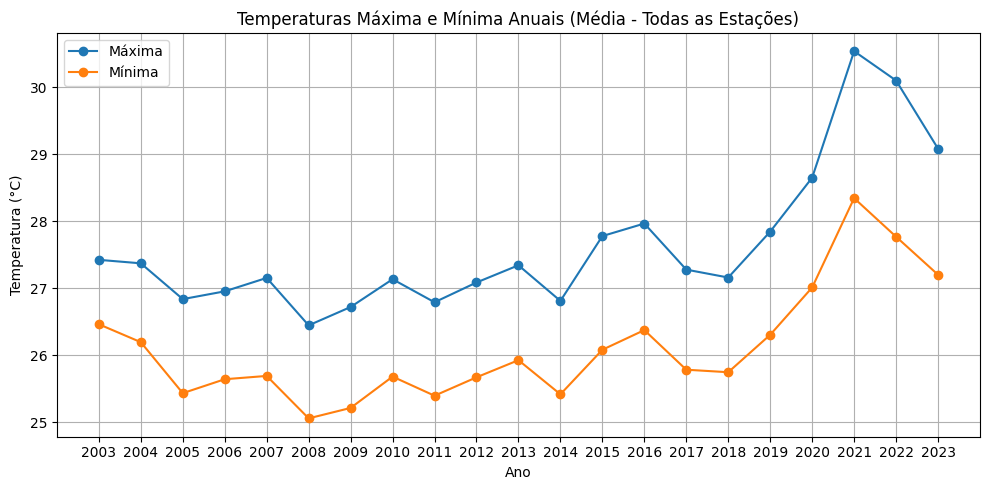

In [10]:
# Visualizar a série temporal
# Criando o gráfico
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais (Média - Todas as Estações)')
plt.xticks(range(2003, 2024))  # Define os ticks do eixo x para cada ano de 2003 a 2022
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta automaticamente os subplots para dar espaço ao conteúdo
plt.show()

# Segmentações ao decorrer dos anos

In [18]:
# Diretório onde os arquivos serão salvos
save_dir = '../dados/segmentacoes'

# Lista de anos
years = range(2000, 2024)  

# Loop para baixar os arquivos
for year in years:
    # Construindo a URL para o ano atual
    url = f'https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_{year}.tif'
    
    # Nome do arquivo local onde o TIF será salvo
    local_filename = f'{save_dir}brasil_coverage_{year}.tif'

    # Fazendo a requisição para baixar o arquivo
    response = requests.get(url)
    
    # Verificando se a requisição foi bem-sucedida
    if response.status_code == 200:
        # Garantindo que o diretório exista
        os.makedirs(save_dir, exist_ok=True)
        
        # Escrevendo o conteúdo do arquivo baixado no arquivo local
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        print(f'Arquivo {local_filename} baixado e salvo com sucesso.')
    else:
        print(f'Falha ao baixar o arquivo para o ano {year}.')

Falha ao baixar o arquivo para o ano 2023.


In [20]:
year = 2023

url = f'https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_9/lclu/coverage/brasil_coverage_2023.tif'
    
# Nome do arquivo local onde o TIF será salvo
local_filename = f'{save_dir}brasil_coverage_{year}.tif'

# Fazendo a requisição para baixar o arquivo
response = requests.get(url)

# Verificando se a requisição foi bem-sucedida
if response.status_code == 200:
    # Garantindo que o diretório exista
    os.makedirs(save_dir, exist_ok=True)
        
    # Escrevendo o conteúdo do arquivo baixado no arquivo local
    with open(local_filename, 'wb') as file:
        file.write(response.content)
    print(f'Arquivo {local_filename} baixado e salvo com sucesso.')
else:
    print(f'Falha ao baixar o arquivo para o ano {year}.')

Arquivo ../dados/segmentacoesbrasil_coverage_2023.tif baixado e salvo com sucesso.


## Agora precisamos delimitar pelas estações na região da caatinga

In [4]:
import basedosdados as bd

In [5]:
# Caminho para o shapefile dos biomas
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'

# Carregar o shapefile dos biomas
biomes = gpd.read_file(biomes_shp)

# Filtrar para obter apenas a Caatinga
caatinga = biomes[biomes['Bioma'] == 'Caatinga']

# Para carregar o dado direto no pandas
df_estacoes = bd.read_table(dataset_id='br_inmet_bdmep',
table_id='estacao',
billing_project_id="projetopdi-430718")

# Convertendo o DataFrame em GeoDataFrame
gdf_estacoes = gpd.GeoDataFrame(
    df_estacoes, 
    geometry=gpd.points_from_xy(df_estacoes['longitude'], df_estacoes['latitude']),
    crs="EPSG:4674"
)

# Reprojetar o GeoDataFrame das estações para o mesmo CRS que o shapefile dos biomas
gdf_estacoes = gdf_estacoes.to_crs(caatinga.crs)

# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

# Dropar colunas que não serão utilizadas
stations_within_caatinga = stations_within_caatinga.drop(columns=['id_municipio', 'estacao','data_fundacao','altitude'])

Downloading: 100%|██████████| 612/612 [00:00<00:00, 1211.59rows/s]


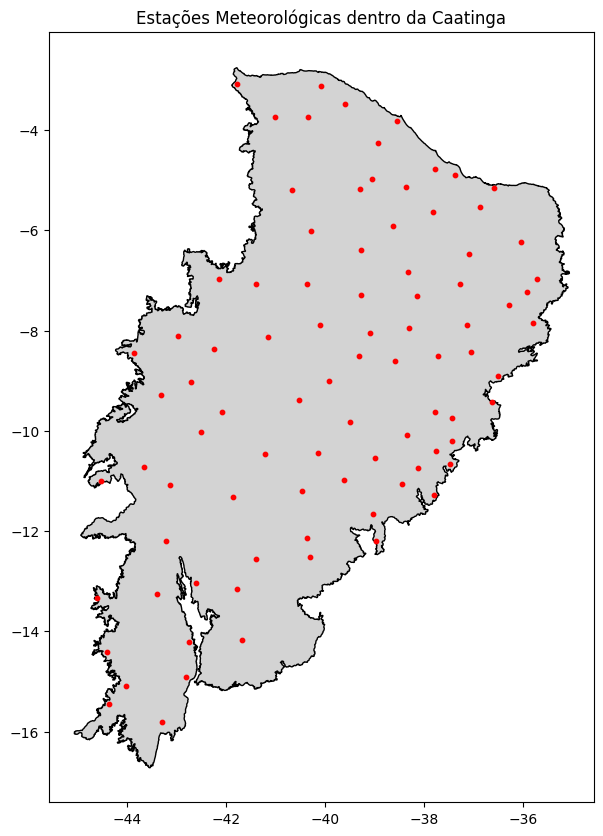

In [291]:
# Plotar um mapa com as estações
fig, ax = plt.subplots(figsize=(10, 10))
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')
stations_within_caatinga.plot(ax=ax, color='red', markersize=10)
plt.title('Estações Meteorológicas dentro da Caatinga')
plt.show()

Precisamos dividir o mapa de acordo com as estações

In [292]:
# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

# Extrair as coordenadas das estações
coords = np.array(list(zip(stations_within_caatinga.geometry.x, stations_within_caatinga.geometry.y)))

# Adicionar pontos fictícios ao redor do perímetro da Caatinga
minx, miny, maxx, maxy = caatinga.total_bounds
padding = 0.5  # Ajuste conforme necessário
extra_points = [
    [minx - padding, miny - padding],
    [minx - padding, maxy + padding],
    [maxx + padding, miny - padding],
    [maxx + padding, maxy + padding]
]

# Adicionar os novos pontos às coordenadas das estações
all_points = np.vstack([coords, extra_points])

# Gerar os polígonos de Voronoi com os pontos adicionais
vor = Voronoi(all_points)

# Criar polígonos de Voronoi a partir dos vértices
polygons = []
for region in vor.regions:
    if not -1 in region and region:
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)

# Criar um GeoDataFrame com os polígonos de Voronoi
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons, crs=stations_within_caatinga.crs)

# Verificar e corrigir geometrias inválidas antes do clipping
gdf_voronoi['geometry'] = gdf_voronoi['geometry'].buffer(0)

# Clipping com o polígono da Caatinga para garantir que todos os polígonos estejam dentro da região
gdf_voronoi_clipped = gpd.GeoDataFrame(
    geometry=[poly.intersection(caatinga.unary_union) for poly in gdf_voronoi.geometry if not poly.is_empty],
    crs=gdf_voronoi.crs
)

# Remover geometrias vazias
gdf_voronoi_clipped = gdf_voronoi_clipped[~gdf_voronoi_clipped.is_empty]

In [293]:
# Associar o polígono ao ID da estação mais próxima
def find_nearest_station(polygon, stations):
    centroid = polygon.centroid
    distances = stations.geometry.apply(lambda x: centroid.distance(x))
    nearest_station = stations.loc[distances.idxmin()]
    return nearest_station['id_estacao'],nearest_station.geometry.y, nearest_station.geometry.x

# Aplicar a função para encontrar o ID da estação, latitude e longitude
gdf_voronoi_clipped[['id_estacao', 'latitude', 'longitude']] = gdf_voronoi_clipped.geometry.apply(
    lambda poly: find_nearest_station(poly, stations_within_caatinga)
).apply(pd.Series)

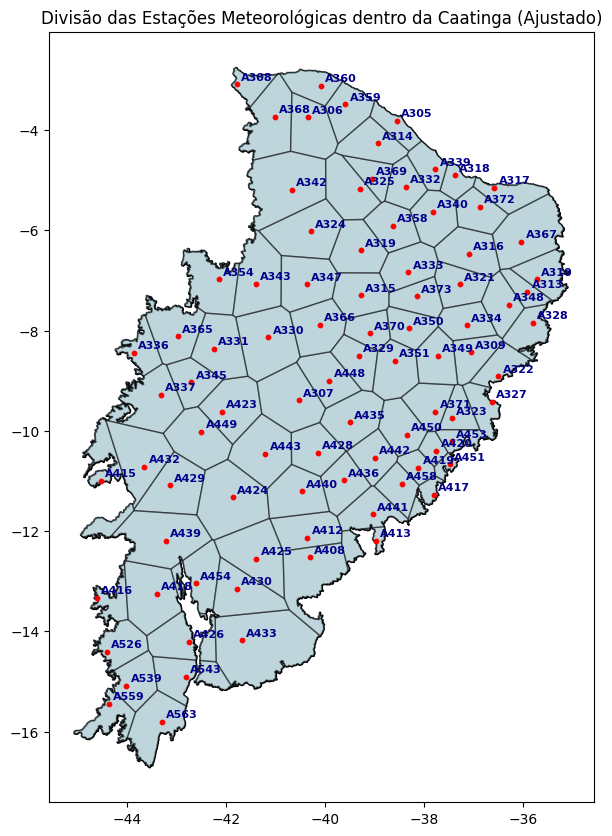

In [294]:
# Plotar o resultado ajustado
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o perímetro da Caatinga
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plotar os polígonos de Voronoi
gdf_voronoi_clipped.plot(ax=ax, edgecolor='black', color='lightblue', alpha=0.5)

# Plotar as estações meteorológicas
stations_within_caatinga.plot(ax=ax, color='red', markersize=10)

# Adicionar o ID das estações no plot
for x, y, label in zip(stations_within_caatinga.geometry.x, stations_within_caatinga.geometry.y, stations_within_caatinga['id_estacao']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='darkblue', weight='bold')

plt.title('Divisão das Estações Meteorológicas dentro da Caatinga (Ajustado)')
plt.show()

In [295]:
# Salvar o shapefile resultante
gdf_voronoi_clipped.to_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')
gdf_voronoi_clipped.head()

geometry id_estacao   latitude  \
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...       A336  -8.441667   
1  MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ...       A365  -8.117939   
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...       A416 -13.332500   
3  POLYGON ((-42.21703 -13.71785, -42.21693 -13.7...       A433 -14.181944   
4  POLYGON ((-41.52190 -3.55804, -41.52253 -3.558...       A308  -3.086667   

   longitude  
0 -43.865556  
1 -42.975721  
2 -44.617500  
3 -41.672222  
4 -41.783056

# Separar os arquivos geotif por estação

In [21]:
# Carregar o shapefile do Voronoi previamente salvo
gdf_voronoi_clipped = gpd.read_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')

In [22]:
def process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped):
    """
    Processa todos os arquivos GeoTIFF na pasta segmentacoes para todas as estações,
    salvando os resultados em pastas separadas por ano.

    Args:
    segmentacoes_dir (str): Caminho para a pasta contendo os arquivos GeoTIFF de entrada.
    output_base_dir (str): Diretório base onde os GeoTIFFs resultantes serão salvos.
    gdf_voronoi_clipped (GeoDataFrame): GeoDataFrame contendo os polígonos de Voronoi.
    """

    # Listar todos os arquivos GeoTIFF na pasta segmentacoes
    tiff_files = glob.glob(os.path.join(segmentacoes_dir, '*.tif'))

    # Obter os IDs únicos das estações
    estacao_ids = gdf_voronoi_clipped['id_estacao'].unique()

    for tiff_file in tiff_files:
        # Extrair o ano do nome do arquivo GeoTIFF
        year = os.path.basename(tiff_file).split('_')[-1].split('.')[0]

        # Criar diretório para o ano se não existir
        year_dir = os.path.join(output_base_dir, year)
        os.makedirs(year_dir, exist_ok=True)

        for estacao_id in estacao_ids:
            # Aplicar a função para salvar o TIFF mascarado
            save_masked_tiff(tiff_file, estacao_id, year_dir, gdf_voronoi_clipped)
            print(f"Salvo: {year_dir}/coverage_{estacao_id}_{year}.tif")


# Definir caminhos
segmentacoes_dir = '../dados/segmentacoes'
output_base_dir = '../dados/raster_tiff_caating'

# Executar o processamento para todos os arquivos e estações
process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped)

Salvo: ../dados/raster_tiff_caating\2000/coverage_A336_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A365_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A416_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A433_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A308_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A368_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A539_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A543_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A526_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A559_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A563_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A454_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A418_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A426_2000.tif
Salvo: ../dados/raster_tiff_caating\2000/coverage_A430_2000.tif
Salvo: ../dados/raster_tiff_caating\2000

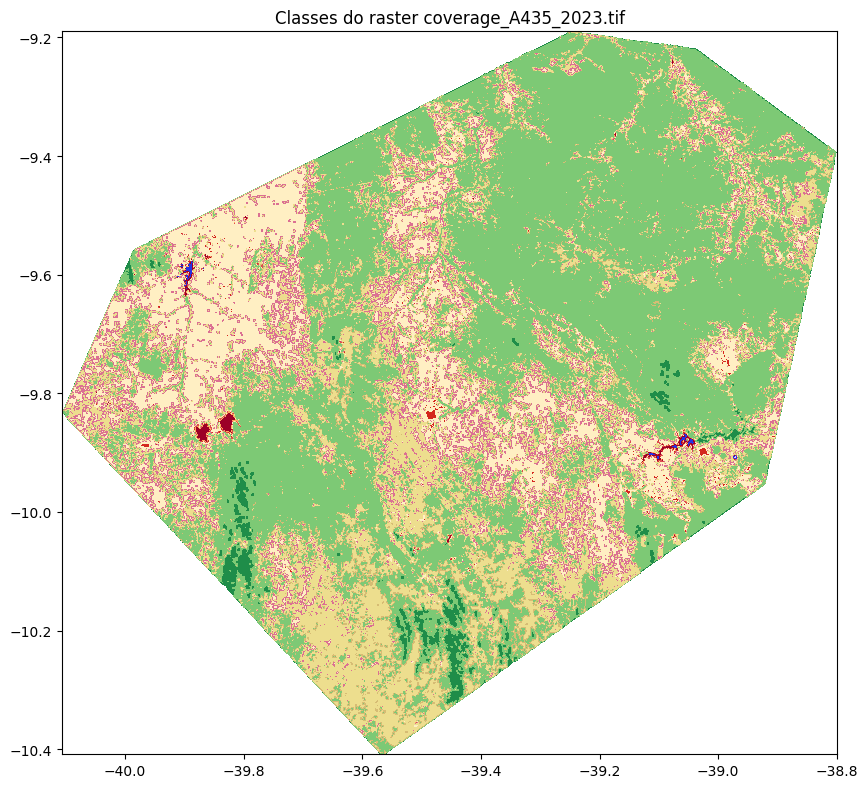

In [26]:
output_tif_path = '../dados/raster_tiff_caating/2023/coverage_A435_2023.tif'
plot_tiff_with_classes(output_tif_path)

In [27]:
# Extrair informações do GeoTIFF salvo
sorted_class_counts = extract_classification_info(output_tif_path)

# Exibir as classificações e contagens
print("Contagem de superpixels por classe (ordenado):", sorted_class_counts)

Contagem de superpixels por classe (ordenado): {np.uint8(20): np.int64(60), np.uint8(48): np.int64(1777), np.uint8(41): np.int64(2107), np.uint8(29): np.int64(4274), np.uint8(30): np.int64(20908), np.uint8(24): np.int64(23145), np.uint8(12): np.int64(23419), np.uint8(33): np.int64(29443), np.uint8(3): np.int64(77902), np.uint8(25): np.int64(181375), np.uint8(15): np.int64(1392739), np.uint8(21): np.int64(5069403), np.uint8(4): np.int64(6624419), np.uint8(0): np.int64(8481056)}


# Série temporal das estações

In [14]:
# Novo dataset com as colunas de interesse
temperaturas = combined_data[['id_estacao','data', 'temperatura_max', 'temperatura_min', 'ano','hora']]
temperaturas.head()

id_estacao        data  temperatura_max  temperatura_min   ano  hora
0       A305  2003-05-31        30.680487        31.487720  2003   4.0
1       A305  2003-06-03        30.777941        31.560665  2003   6.0
2       A305  2003-06-03        30.893936        31.738571  2003  21.0
3       A305  2003-06-06        30.893936        31.703011  2003  21.0
4       A305  2003-06-09        30.698698        31.493439  2003  10.0

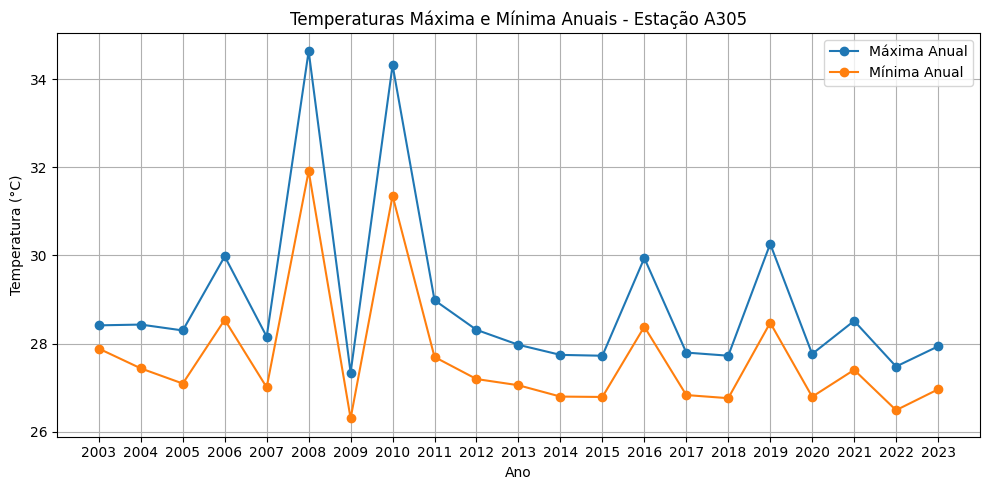

In [31]:
# Filtrar os dados apenas para a estação A305
dados_A305 = temperaturas[temperaturas['id_estacao'] == 'A305']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_A305.groupby('ano').agg(
    temperatura_max=('temperatura_max', 'mean'),
    temperatura_min=('temperatura_min', 'mean')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais - Estação A305')
plt.xticks(range(temperatura_anual['ano'].min(), temperatura_anual['ano'].max() + 1))  # Define os ticks do eixo x para cada ano
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Série temporal da vegetação na região de cada estação

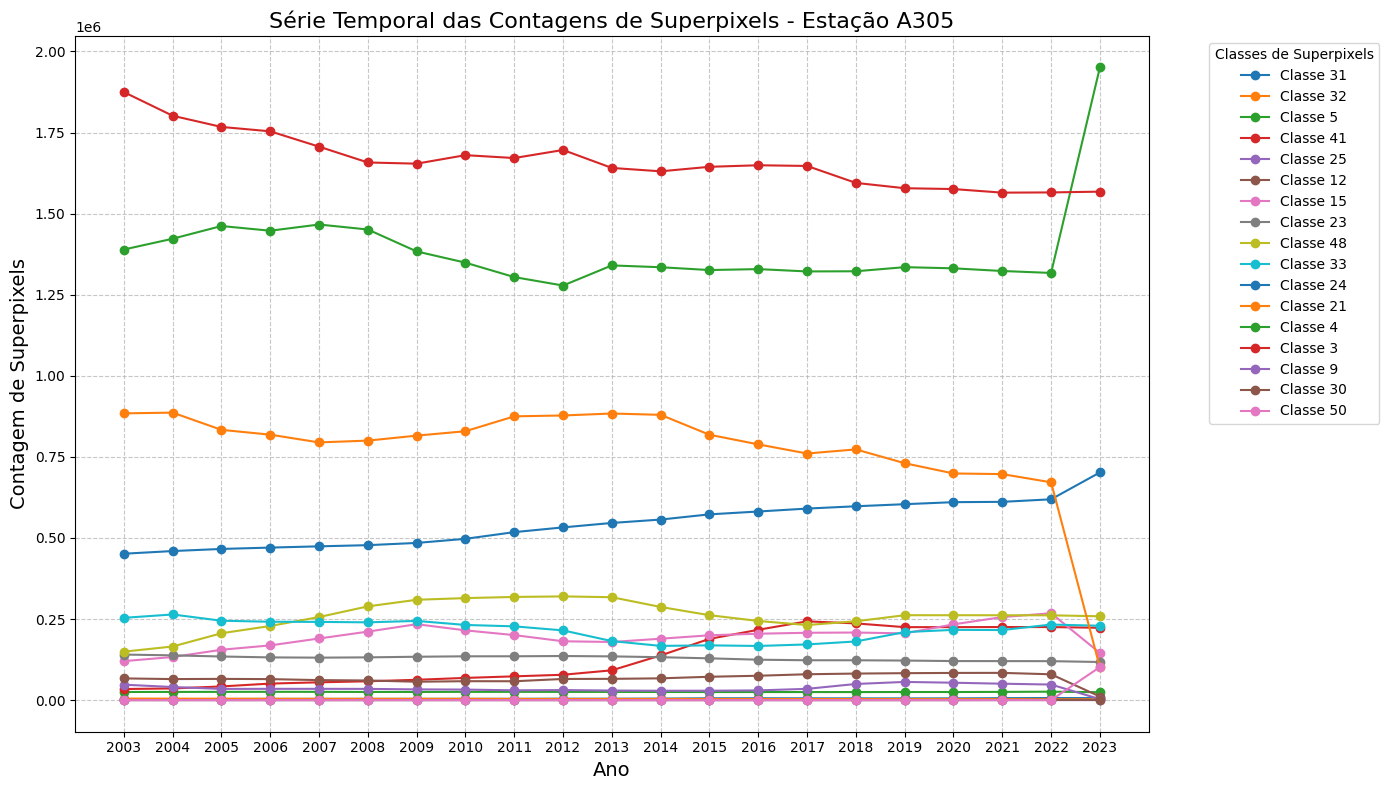

In [32]:
# Definir parâmetros
output_base_dir = '../dados/raster_tiff_caating'
estacao_id = 'A305'
start_year = 2003
end_year = 2023

# Criar a série temporal
df_time_series = create_time_series(output_base_dir, estacao_id, start_year, end_year)
plot_time_series(df_time_series, estacao_id)

## Montagem do dataset para cada estação

In [33]:
output_base_dir = '../dados/raster_tiff_caating'
estacao_id = 'A305'
start_year = 2003
end_year = 2023

# DataFrame inicial com os dados de temperatura
dados_A305 = temperaturas[temperaturas['id_estacao'] == estacao_id]

# Criar o dataset completo para a estação A305
dataset_completo_A305 = criar_dataset_completo(dados_A305, output_base_dir, estacao_id, start_year, end_year)

In [34]:
dataset_completo_A305.head()

ano  temperatura_max  temperatura_min      31      32        5       41  \
0  2003        28.412598        27.883399  2574.0  4683.0  24970.0  34098.0   
1  2004        28.430250        27.434692  2761.0  4410.0  25162.0  35944.0   
2  2005        28.296701        27.090051  3344.0  4303.0  25392.0  42089.0   
3  2006        29.979536        28.540057  3677.0  4081.0  25559.0  50899.0   
4  2007        28.155603        27.002405  3748.0  3909.0  25426.0  54823.0   

        25       12        15        23        48        33        24  \
0  47489.0  66877.0  120126.0  140382.0  149318.0  253628.0  451289.0   
1  40349.0  64771.0  132801.0  137925.0  165220.0  263979.0  459531.0   
2  34459.0  65402.0  155191.0  134406.0  206048.0  244677.0  466019.0   
3  34696.0  64630.0  168667.0  131636.0  228522.0  241594.0  470223.0   
4  34702.0  61626.0  189931.0  130868.0  256069.0  241064.0  474057.0   

         21          4          3    9   30   50  
0  884053.0  1389258.0  1874707.0  0.0  0.0  0.0  
1  886343.0  1422501.0  1801735.0  0.0  0.0  0.0  
2  833253.0  1461676.0  1767177.0  0.0  0.0  0.0  
3  818379.0  1447196.0  1753663.0  0.0  0.0  0.0  
4  794502.0  1466322.0  1706385.0  0.0  0.0  0.0

# Utilizando o coeficiente de correlação de Pearson

In [15]:
# Dicionário de mapeamento de IDs para nomes das classes
id_to_class_name = {
    1: "Formação Florestal",
    3: "Formação Florestal",
    4: "Formação Savânica",
    5: "Mangue",
    6: "Floresta Alagável",
    49: "Restinga Arbórea",
    11: "Campo Alagado e Área Pantanosa",
    12: "Formação Campestre ",
    32: "Apicum",
    29: "Afloramento Rochoso",
    50: "Restinga Herbácea",
    13: "Outras Formações Não Florestais",
    14: "Agropecuária",
    15: "Pastagem",
    18: "Agricultura",
    19: "Lavoura Temporária",
    39: "Soja",
    20: "Cana",
    40: "Arroz",
    62: "Algodão (beta)",
    41: "Outras Lavouras Temporárias",
    36: "Lavoura Perene",
    21: "Mosaico de Usos",
    46: "Café",
    47: "Citros",
    35: "Dendê (beta)",
    48: "Outras Lavouras Perenes",
    9: "Silvicultura",
    23: "Praia, Duna e Areal",
    24: "Área Urbanizada",
    30: "Mineração",
    25: "Outras Áreas não Vegetadas",
    33: "Rio, Lago e Oceano ",
    31: "Aquicultura",
    27: "Não Observado",
    26: "Corpo d'água",
    22: "Área não Vegetada",
    10: "Formação Natural não Florestal",
    0: "Não Classificado",

}

Text(143.72222222222223, 0.5, 'Classes de Vegetação')

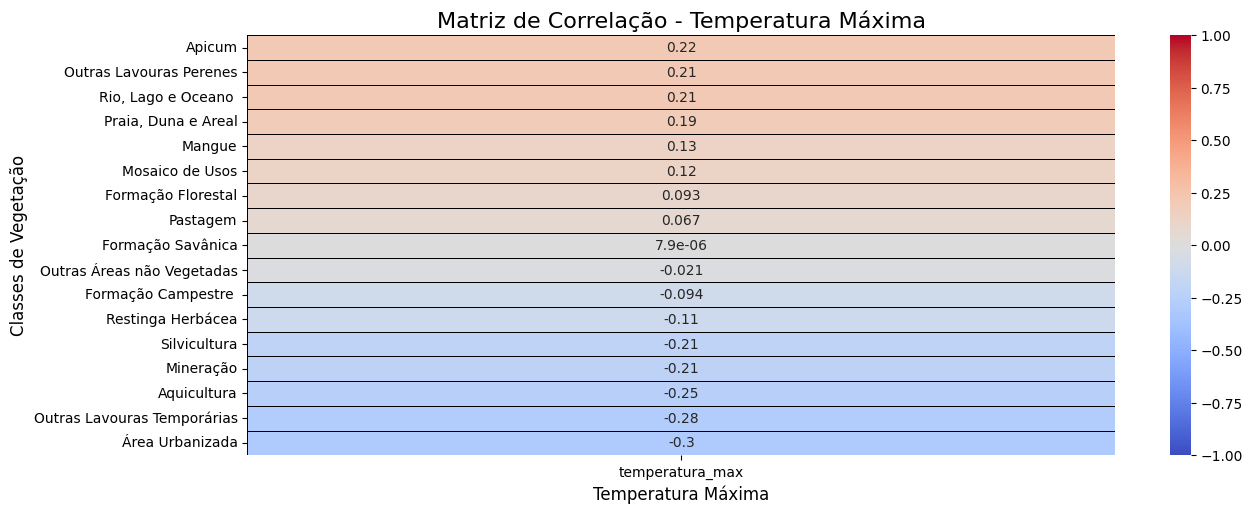

In [36]:
# Calcular a matriz de correlação para todas as colunas
correlation_matrix = dataset_completo_A305.corr(method='pearson')

# Focar apenas na correlação da temperatura máxima com as classes de vegetação
correlation_max = correlation_matrix[['temperatura_max']].drop(['ano', 'temperatura_max', 'temperatura_min'])

# Mapeando os nomes das classes no eixo y
correlation_max.index = correlation_max.index.map(id_to_class_name)

# Focar apenas na correlação da temperatura mínima com as classes de vegetação
correlation_min = correlation_matrix[['temperatura_min']].drop(['ano', 'temperatura_max', 'temperatura_min'])

# Mapeando os nomes das classes no eixo y
correlation_min.index = correlation_min.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlation_max = correlation_max.sort_values(by='temperatura_max', ascending=False)
correlation_min = correlation_min.sort_values(by='temperatura_min', ascending=False)

# Configurar o tamanho do plot e criar duas subplots
plt.figure(figsize=(14, 12))

# Heatmap para Temperatura Máxima
plt.subplot(2, 1, 1)
sns.heatmap(correlation_max, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Matriz de Correlação - Temperatura Máxima', fontsize=16)
plt.xlabel('Temperatura Máxima', fontsize=12)
plt.ylabel('Classes de Vegetação', fontsize=12)

Text(143.72222222222223, 0.5, 'Classes de Vegetação')

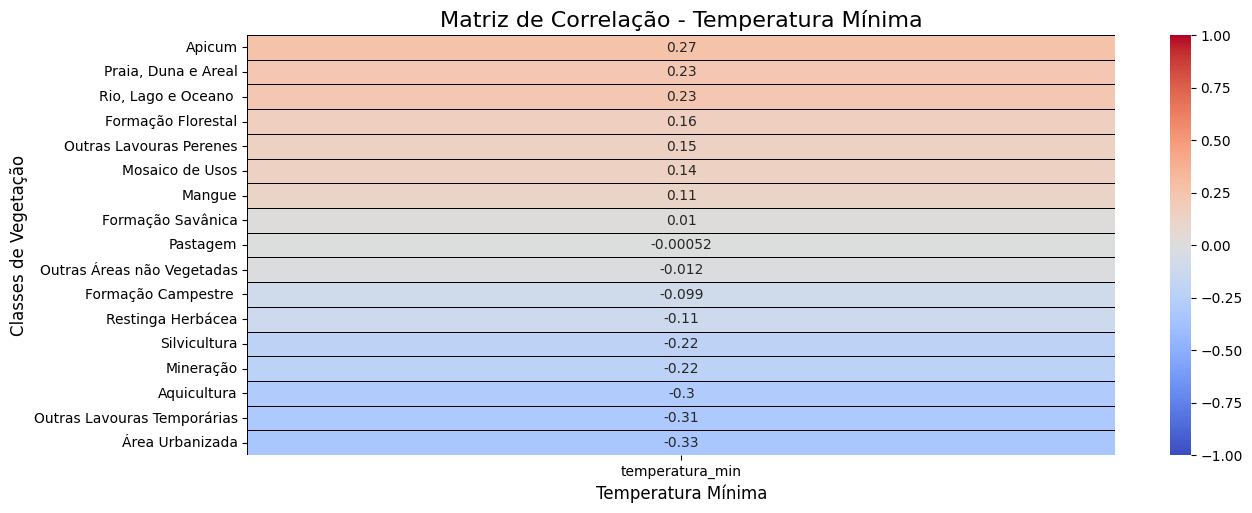

In [37]:
# Heatmap para Temperatura Mínima
plt.figure(figsize=(14, 12))
plt.subplot(2, 1, 2)
sns.heatmap(correlation_min, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Matriz de Correlação - Temperatura Mínima', fontsize=16)
plt.xlabel('Temperatura Mínima', fontsize=12)
plt.ylabel('Classes de Vegetação', fontsize=12)

# Verificando a correlação utilizando mais de uma estação

In [16]:
# Carregar o shapefile do Voronoi previamente salvo
gdf_voronoi_clipped = gpd.read_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')

# Removendo regiões com uma área muito grande em estacoes_validas
gdf_voronoi_validas_filter = gdf_voronoi_clipped[gdf_voronoi_clipped.area < 0.8]
gdf_voronoi_validas_filter.head()

C:\Users\arthu\AppData\Local\Temp\ipykernel_16456\370575154.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_voronoi_validas_filter = gdf_voronoi_clipped[gdf_voronoi_clipped.area < 0.8]


id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
2       A416 -13.332500 -44.617500   
4       A308  -3.086667 -41.783056   
6       A539 -15.085958 -44.016036   
8       A526 -14.408333 -44.404167   

                                            geometry  
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...  
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...  
4  POLYGON ((-41.5219 -3.55804, -41.52253 -3.5580...  
6  MULTIPOLYGON (((-43.82896 -15.61738, -44.27226...  
8  MULTIPOLYGON (((-44.446 -13.85756, -44.44638 -...

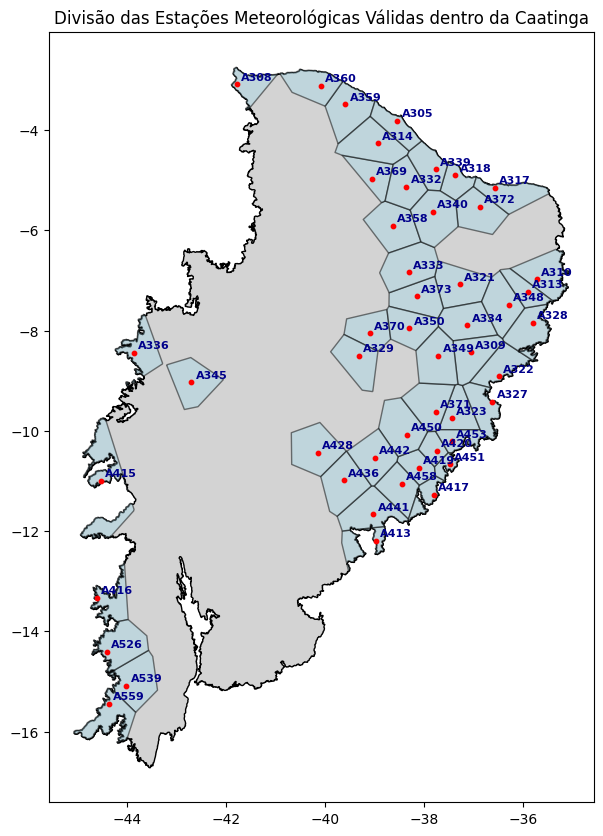

In [7]:
# Filtrar as estações meteorológicas para incluir apenas as estações válidas
stations_validas = stations_within_caatinga[stations_within_caatinga['id_estacao'].isin(gdf_voronoi_validas_filter['id_estacao'])]

# Plotar o resultado ajustado
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o perímetro da Caatinga
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plotar os polígonos de Voronoi para as estações válidas
gdf_voronoi_validas_filter.plot(ax=ax, edgecolor='black', color='lightblue', alpha=0.5)

# Plotar as estações meteorológicas válidas
stations_validas.plot(ax=ax, color='red', markersize=10)

# Adicionar o ID das estações válidas no plot
for x, y, label in zip(stations_validas.geometry.x, stations_validas.geometry.y, stations_validas['id_estacao']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='darkblue', weight='bold')

plt.title('Divisão das Estações Meteorológicas Válidas dentro da Caatinga')
plt.show()

In [39]:
# Lista para armazenar os DataFrames de cada estação
datasets_completos = []
output_base_dir = '../dados/raster_tiff_caating'
start_year = 2003
end_year = 2023

# Iterar sobre cada estação e criar o dataset completo
for estacao_id in gdf_voronoi_validas_filter['id_estacao']:
    # Criar o dataset completo para a estação atual
    dataset_completo = criar_dataset_completo(temperaturas, output_base_dir, estacao_id, start_year, end_year)
    
    # Adicionar o ID da estação ao DataFrame
    dataset_completo['id_estacao'] = estacao_id
    
    # Adicionar o dataset da estação à lista
    datasets_completos.append(dataset_completo)

# Concatenar todos os DataFrames em um único DataFrame
dataset_completo_todas_estacoes = pd.concat(datasets_completos, ignore_index=True)

# Substituir valores NaN por 0
dataset_completo_todas_estacoes.fillna(0, inplace=True)

# Remover colunas onde todos os valores são 0
dataset_completo_todas_estacoes = dataset_completo_todas_estacoes.loc[:, (dataset_completo_todas_estacoes != 0).any(axis=0)]

# Exibir as primeiras linhas do DataFrame final
dataset_completo_todas_estacoes.head()

ano  temperatura_max  temperatura_min    39      33      41      24  \
0  2007        30.133520        28.095121  26.0  1268.0  1810.0  7346.0   
1  2008        27.921808        26.246671  87.0  1268.0  1932.0  7440.0   
2  2009        26.890393        25.767189   2.0  1238.0  3698.0  7543.0   
3  2010        28.313076        27.209743   0.0  1179.0  4500.0  7632.0   
4  2011        27.621189        26.424989   0.0  1092.0  3680.0  7730.0   

        25        15        12  ...  id_estacao   46   48   31   32    5   23  \
0  46448.0  162724.0  134422.0  ...        A336  0.0  0.0  0.0  0.0  0.0  0.0   
1  44194.0  176902.0  133308.0  ...        A336  0.0  0.0  0.0  0.0  0.0  0.0   
2  37061.0  200726.0  145177.0  ...        A336  0.0  0.0  0.0  0.0  0.0  0.0   
3  29335.0  196661.0  189262.0  ...        A336  0.0  0.0  0.0  0.0  0.0  0.0   
4  21856.0  204480.0  209070.0  ...        A336  0.0  0.0  0.0  0.0  0.0  0.0   

    20   30   50  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0  

[5 rows x 27 columns]

In [40]:
# salvar o dataset completo
dataset_completo_todas_estacoes.to_csv('../dados/dataset_completo_todas_estacoes_1.csv', index=False)

In [41]:
dataset_completo_todas_estacoes = pd.read_csv('../dados/dataset_completo_todas_estacoes_1.csv')

# quantos anos de dados temos para cada estação?
dataset_completo_todas_estacoes['id_estacao'].value_counts()

id_estacao
A308    21
A305    21
A309    20
A310    20
A313    18
A336    17
A416    17
A539    17
A526    17
A333    17
A329    17
A417    17
A334    17
A415    17
A322    17
A413    17
A321    17
A332    17
A323    17
A314    17
A327    17
A318    17
A340    17
A317    17
A339    17
A348    16
A328    16
A442    16
A428    16
A441    16
A345    16
A359    16
A436    16
A349    16
A358    16
A350    16
A419    16
A360    15
A420    15
A450     9
A559     8
A373     7
A453     7
A451     7
A370     7
A371     7
A372     7
A369     6
A458     6
Name: count, dtype: int64

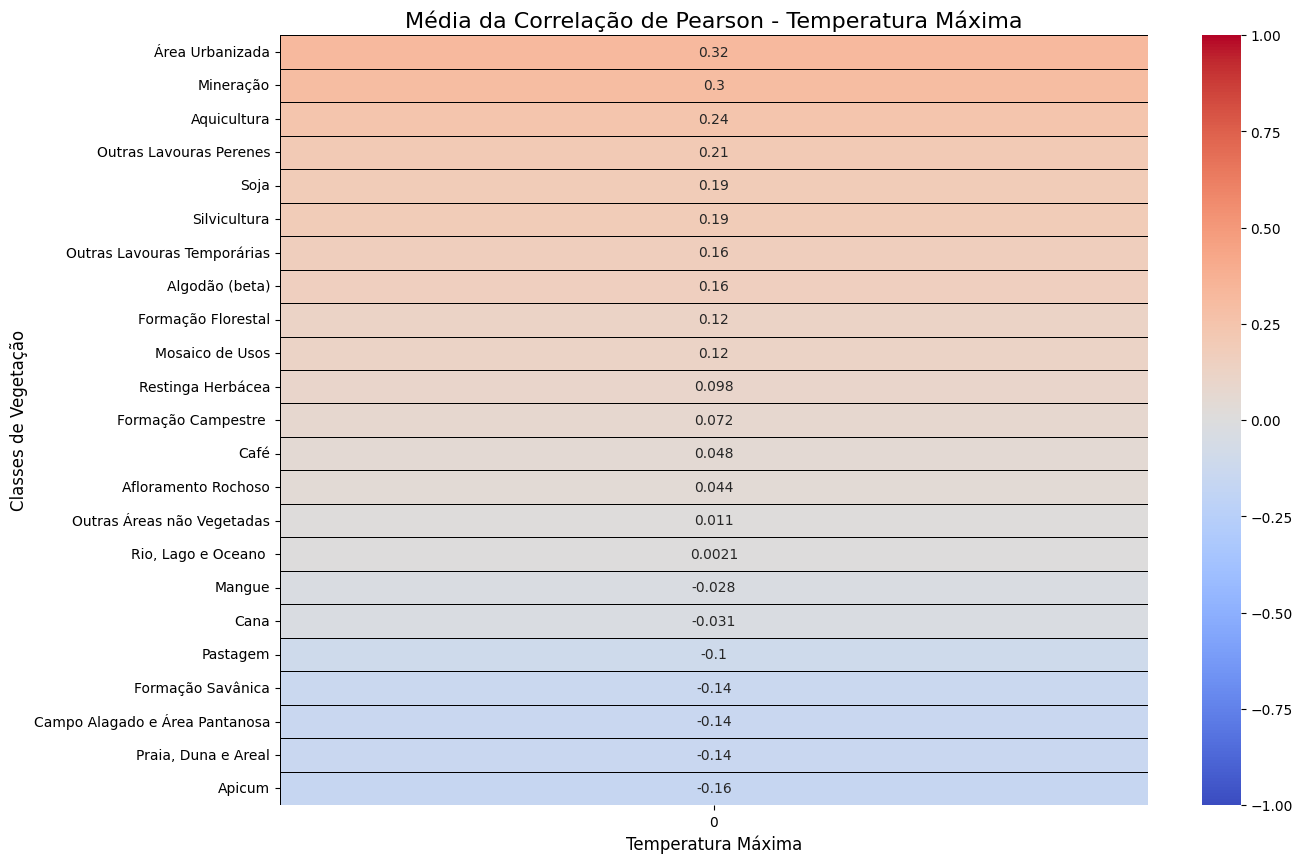

In [42]:
# Dicionário para armazenar as correlações de cada estação
correlacoes_por_estacao = {}

# Iterar por cada estação e calcular a correlação
for estacao_id in gdf_voronoi_validas_filter['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura máxima
    correlacao_temp_max = dados_para_correlacao.corr(method='pearson')['temperatura_max']
    
    # Remover a autocorrelação (correlação da temperatura máxima com ela mesma)
    correlacao_temp_max = correlacao_temp_max.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao[estacao_id] = correlacao_temp_max

# Combinar todas as correlações e calcular a média
correlacoes_media = pd.DataFrame(correlacoes_por_estacao).mean(axis=1)

# Converter os índices da série para inteiros antes de mapear os nomes das classes
correlacoes_media.index = correlacoes_media.index.astype(int)

# Mapeando os nomes das classes no eixo y
correlacoes_media.index = correlacoes_media.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media = correlacoes_media.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura máxima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Máxima', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Máxima', fontsize=12)
plt.show()

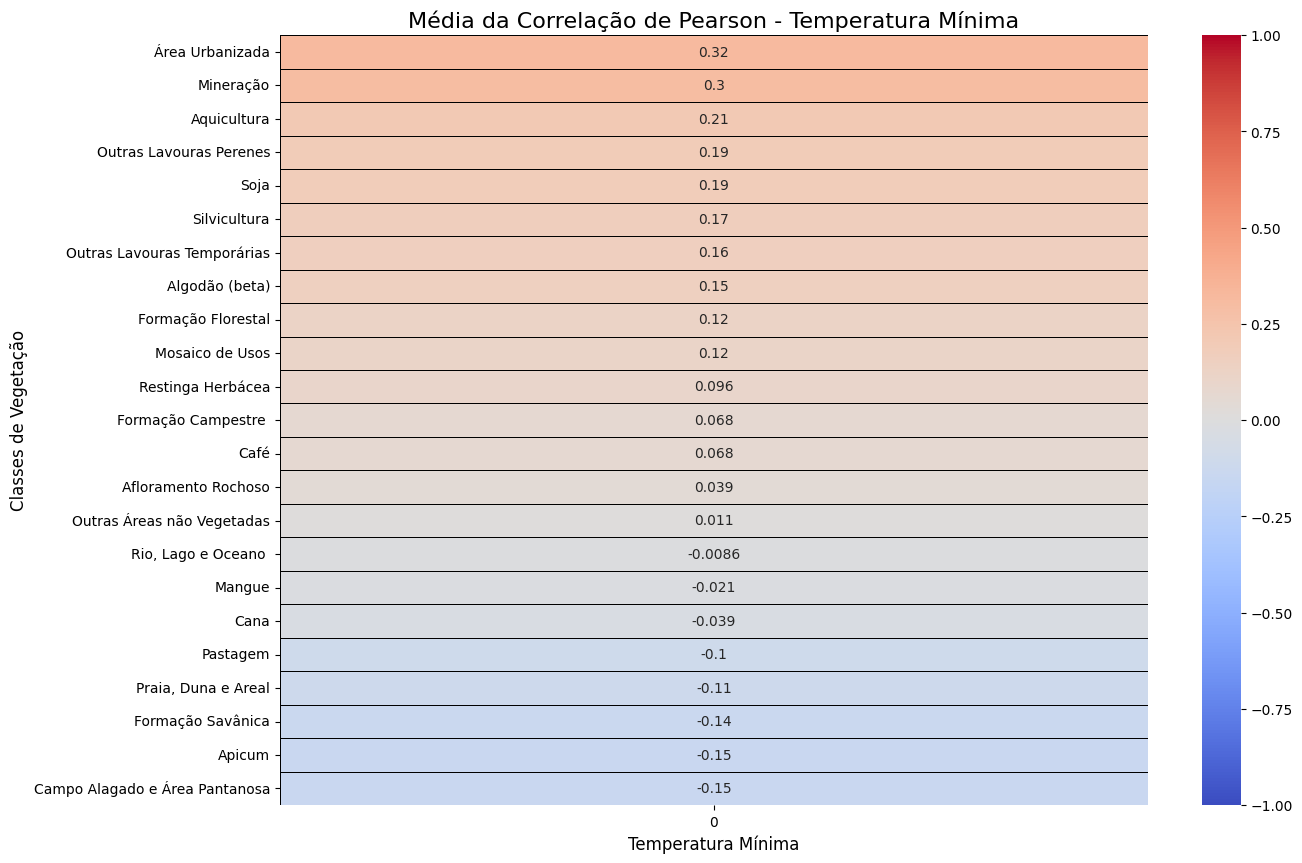

In [43]:
# Dicionário para armazenar as correlações de cada estação para temperatura mínima
correlacoes_por_estacao_min = {}

# Iterar por cada estação e calcular a correlação para a temperatura mínima
for estacao_id in gdf_voronoi_validas_filter['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura mínima
    correlacao_temp_min = dados_para_correlacao.corr(method='pearson')['temperatura_min']
    
    # Remover a autocorrelação (correlação da temperatura mínima com ela mesma)
    correlacao_temp_min = correlacao_temp_min.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao_min[estacao_id] = correlacao_temp_min

# Combinar todas as correlações e calcular a média
correlacoes_media_min = pd.DataFrame(correlacoes_por_estacao_min).mean(axis=1)

# Converter os índices da série para inteiros antes de mapear os nomes das classes
correlacoes_media_min.index = correlacoes_media_min.index.astype(int)

# Mapeando os nomes das classes no eixo y
correlacoes_media_min.index = correlacoes_media_min.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media_min = correlacoes_media_min.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura mínima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media_min.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Mínima', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Mínima', fontsize=12)
plt.show()

In [17]:
# Lista para armazenar os DataFrames de cada estação
datasets_completos = []
output_base_dir = '../dados/raster_tiff_caating'
start_year = 2003
end_year = 2023

# Iterar sobre cada estação e criar o dataset completo
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Criar o dataset completo para a estação atual
    dataset_completo = criar_dataset_completo(temperaturas, output_base_dir, estacao_id, start_year, end_year)
    
    # Adicionar o ID da estação ao DataFrame
    dataset_completo['id_estacao'] = estacao_id
    
    # Adicionar o dataset da estação à lista
    datasets_completos.append(dataset_completo)

# Concatenar todos os DataFrames em um único DataFrame
dataset_completo_todas_estacoes = pd.concat(datasets_completos, ignore_index=True)

# Substituir valores NaN por 0
dataset_completo_todas_estacoes.fillna(0, inplace=True)

# Remover colunas onde todos os valores são 0
dataset_completo_todas_estacoes = dataset_completo_todas_estacoes.loc[:, (dataset_completo_todas_estacoes != 0).any(axis=0)]

# Exibir as primeiras linhas do DataFrame final
dataset_completo_todas_estacoes.head()

ano  temperatura_max  temperatura_min    39      33      41      24  \
0  2007        30.133520        28.095121  26.0  1268.0  1810.0  7346.0   
1  2008        27.921808        26.246671  87.0  1268.0  1932.0  7440.0   
2  2009        26.890393        25.767189   2.0  1238.0  3698.0  7543.0   
3  2010        28.313076        27.209743   0.0  1179.0  4500.0  7632.0   
4  2011        27.621189        26.424989   0.0  1092.0  3680.0  7730.0   

        25        15        12  ...   48   30   31   32    5   23   20   50  \
0  46448.0  162724.0  134422.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  44194.0  176902.0  133308.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  37061.0  200726.0  145177.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  29335.0  196661.0  189262.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  21856.0  204480.0  209070.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    13   49  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 29 columns]

In [18]:
dataset_completo_todas_estacoes.to_csv('../dados/dataset_completo_todas_estacoes_2.csv', index=False)

In [19]:
dataset_completo_todas_estacoes = pd.read_csv('../dados/dataset_completo_todas_estacoes_2.csv')

In [20]:
# Dicionário para armazenar as correlações de cada estação
correlacoes_por_estacao = {}

# Iterar por cada estação e calcular a correlação
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura máxima
    correlacao_temp_max = dados_para_correlacao.corr(method='pearson')['temperatura_max']
    
    # Remover a autocorrelação (correlação da temperatura máxima com ela mesma)
    correlacao_temp_max = correlacao_temp_max.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao[estacao_id] = correlacao_temp_max


# Transformar o dicionário de correlações em um DataFrame para temperatura máxima
df_correlacoes_max = pd.DataFrame(correlacoes_por_estacao).T

# Resetar o índice para transformar o 'id_estacao' em uma coluna
df_correlacoes_max.reset_index(inplace=True)

# Renomear a coluna de índice para 'id_estacao'
df_correlacoes_max.rename(columns={'index': 'id_estacao'}, inplace=True)

# Mapear os IDs das classes para os nomes das classes nas colunas
df_correlacoes_max.columns = ['id_estacao'] + [id_to_class_name.get(int(col), col) for col in df_correlacoes_max.columns[1:]]

# Transformar NaN em 0
df_correlacoes_max.fillna(0, inplace=True)

# Exibir o DataFrame de correlações para temperatura máxima
df_correlacoes_max.head()

id_estacao      Soja  Rio, Lago e Oceano   Outras Lavouras Temporárias  \
0       A336  0.350749            -0.157287                     0.309828   
1       A365  0.174397            -0.070975                    -0.123244   
2       A416 -0.307334             0.226208                    -0.135216   
3       A433  0.000000            -0.182778                     0.263420   
4       A308 -0.106027            -0.048895                     0.217495   

   Área Urbanizada  Outras Áreas não Vegetadas  Pastagem  Formação Campestre   \
0         0.618306                    0.249026 -0.138743            -0.571576   
1        -0.010485                    0.541580  0.067857            -0.068855   
2        -0.207359                    0.194809 -0.041111            -0.107021   
3         0.216901                   -0.306520  0.311330             0.187917   
4         0.062778                    0.288462  0.260918            -0.140195   

   Mosaico de Usos  Formação Florestal  ...  Outras Lavouras Perenes  \
0        -0.290278            0.156042  ...                 0.000000   
1        -0.368155            0.047860  ...                 0.000000   
2        -0.164867           -0.091401  ...                -0.185608   
3        -0.075783            0.347736  ...                 0.434464   
4         0.161857            0.049925  ...                 0.076459   

   Mineração  Aquicultura    Apicum    Mangue  Praia, Duna e Areal  Cana  \
0   0.000000     0.000000  0.000000  0.000000              0.00000   0.0   
1   0.000000     0.000000  0.000000  0.000000              0.00000   0.0   
2   0.000000     0.000000  0.000000  0.000000              0.00000   0.0   
3   0.282314     0.000000  0.000000  0.000000              0.00000   0.0   
4   0.000000     0.031925 -0.048494  0.210283              0.00495   0.0   

   Restinga Herbácea  Outras Formações Não Florestais  Restinga Arbórea  
0                0.0                              0.0               0.0  
1                0.0                              0.0               0.0  
2                0.0                              0.0               0.0  
3                0.0                              0.0               0.0  
4                0.0                              0.0               0.0  

[5 rows x 26 columns]

In [21]:
# Dicionário para armazenar as correlações de cada estação para temperatura mínima
correlacoes_por_estacao_min = {}

# Iterar por cada estação e calcular a correlação para a temperatura mínima
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura mínima
    correlacao_temp_min = dados_para_correlacao.corr(method='pearson')['temperatura_min']
    
    # Remover a autocorrelação (correlação da temperatura mínima com ela mesma)
    correlacao_temp_min = correlacao_temp_min.drop(labels=['temperatura_max', 'temperatura_min'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao_min[estacao_id] = correlacao_temp_min

# Transformar o dicionário de correlações em um DataFrame para temperatura mínima
df_correlacoes_min = pd.DataFrame(correlacoes_por_estacao_min).T

# Resetar o índice para transformar o 'id_estacao' em uma coluna
df_correlacoes_min.reset_index(inplace=True)

# Renomear a coluna de índice para 'id_estacao'
df_correlacoes_min.rename(columns={'index': 'id_estacao'}, inplace=True)

# Mapear os IDs das classes para os nomes das classes nas colunas
df_correlacoes_min.columns = ['id_estacao'] + [id_to_class_name.get(int(col), col) for col in df_correlacoes_min.columns[1:]]

# Transformar NaN em 0
df_correlacoes_min.fillna(0, inplace=True)

# Exibir o DataFrame de correlações para temperatura mínima
df_correlacoes_min.head()

id_estacao      Soja  Rio, Lago e Oceano   Outras Lavouras Temporárias  \
0       A336  0.377789            -0.167199                     0.332568   
1       A365  0.191805            -0.073338                    -0.103071   
2       A416 -0.260007             0.211494                    -0.072291   
3       A433  0.000000            -0.182941                     0.221500   
4       A308 -0.064521            -0.130779                     0.150414   

   Área Urbanizada  Outras Áreas não Vegetadas  Pastagem  Formação Campestre   \
0         0.582083                    0.208957 -0.173051            -0.508427   
1         0.000619                    0.573666  0.050110            -0.087576   
2        -0.175287                    0.144355 -0.005422            -0.079877   
3         0.145289                   -0.312180  0.242816             0.165340   
4        -0.000840                    0.217407  0.105106            -0.120728   

   Mosaico de Usos  Formação Florestal  ...  Outras Lavouras Perenes  \
0        -0.252162            0.091886  ...                 0.000000   
1        -0.387376            0.060632  ...                 0.000000   
2        -0.143263           -0.078844  ...                -0.193327   
3        -0.061113            0.263927  ...                 0.303317   
4         0.105626            0.074181  ...                 0.013964   

   Mineração  Aquicultura    Apicum    Mangue  Praia, Duna e Areal  Cana  \
0   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
1   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
2   0.000000     0.000000  0.000000  0.000000             0.000000   0.0   
3   0.185053     0.000000  0.000000  0.000000             0.000000   0.0   
4   0.000000    -0.051073 -0.047888  0.145989             0.116917   0.0   

   Restinga Herbácea  Outras Formações Não Florestais  Restinga Arbórea  
0                0.0                              0.0               0.0  
1                0.0                              0.0               0.0  
2                0.0                              0.0               0.0  
3                0.0                              0.0               0.0  
4                0.0                              0.0               0.0  

[5 rows x 26 columns]

In [22]:
def plot_heatmap_correlacao_por_estacao(df_correlacoes, id_estacao, tipo_temperatura='min', cmap='coolwarm'):
    """
    Plota um heatmap de correlações para uma estação específica com estilo consistente ao heatmap médio.
    
    Parâmetros:
    - df_correlacoes: DataFrame com as correlações das estações (df_correlacoes_min ou df_correlacoes_max).
                       Deve conter uma coluna 'id_estacao' e outras colunas correspondentes aos nomes das classes.
    - id_estacao: ID da estação (string ou inteiro) que você deseja visualizar.
    - tipo_temperatura: 'min' para temperatura mínima ou 'max' para temperatura máxima.
    - cmap: Mapa de cores para o heatmap. Default é 'coolwarm'.
    """
    # Verificar se 'id_estacao' está no DataFrame
    if 'id_estacao' not in df_correlacoes.columns:
        print("O DataFrame fornecido não contém a coluna 'id_estacao'.")
        return
    
    # Filtrar o DataFrame para a estação específica
    station_data = df_correlacoes[df_correlacoes['id_estacao'] == id_estacao]
    
    if station_data.empty:
        print(f"Nenhuma correlação encontrada para a estação {id_estacao}.")
        return
    
    # Remover a coluna 'id_estacao'
    correlations = station_data.drop('id_estacao', axis=1)
    
    # Transpor para ter classes como índice
    correlations = correlations.T
    
    # Renomear a coluna para 'Correlação'
    correlations.columns = ['Correlação']
    
    # Ordenar as correlações da maior para a menor
    correlations_sorted = correlations.sort_values(by='Correlação', ascending=False)
    
    # Configurar o estilo do plot para ser consistente
    plt.figure(figsize=(14, 10))
    sns.set(style="whitegrid")
    
    # Plotar o heatmap
    sns.heatmap(
        correlations_sorted,
        annot=True,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='black',
        cbar=True,
        fmt=".2f",
        annot_kws={"size": 12}
    )
    
    # Definir títulos e labels
    plt.title(f'Correlação de Pearson - Temperatura {"Mínima" if tipo_temperatura == "min" else "Máxima"} - Estação {id_estacao}', fontsize=16)
    plt.ylabel('Classes de Vegetação', fontsize=12)
    plt.xlabel(f'Temperatura {"Mínima" if tipo_temperatura == "min" else "Máxima"}', fontsize=12)
    
    # Ajustar layout para melhor visualização
    plt.tight_layout()
    
    # Exibir o heatmap
    plt.show()

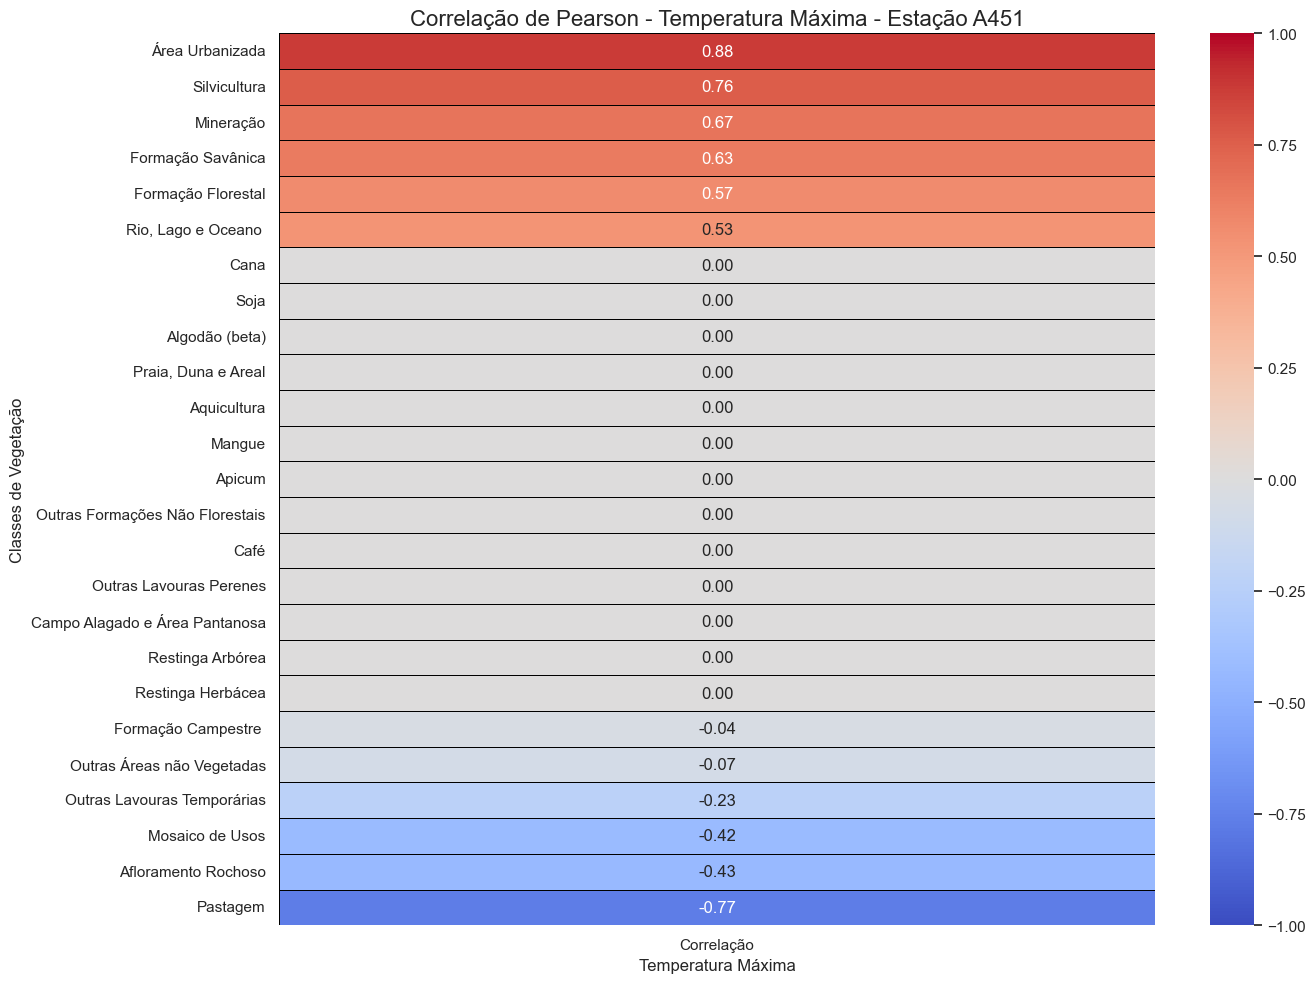

In [23]:
plot_heatmap_correlacao_por_estacao(
    df_correlacoes=df_correlacoes_min,
    id_estacao='A451',  
    tipo_temperatura='max',
    cmap='coolwarm'
)

Valores NaN representam as classes que não possuem mudanças, a variância de uma variável constante é zero. Foram preenchidos com 0.

In [49]:
# arredondar para 3 casas decimais
df_correlacoes_max = df_correlacoes_max.round(3)
df_correlacoes_min = df_correlacoes_min.round(3)

# trocar ponto por vírgula
df_correlacoes_max = df_correlacoes_max.applymap(lambda x: str(x).replace('.', ','))
df_correlacoes_min = df_correlacoes_min.applymap(lambda x: str(x).replace('.', ','))

C:\Users\arthu\AppData\Local\Temp\ipykernel_10588\3952907751.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_correlacoes_max = df_correlacoes_max.applymap(lambda x: str(x).replace('.', ','))
C:\Users\arthu\AppData\Local\Temp\ipykernel_10588\3952907751.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_correlacoes_min = df_correlacoes_min.applymap(lambda x: str(x).replace('.', ','))


In [50]:
df_correlacoes_max.head()

id_estacao    Soja Rio, Lago e Oceano  Outras Lavouras Temporárias  \
0       A336   0,351              -0,157                        0,31   
1       A365   0,174              -0,071                      -0,123   
2       A416  -0,307               0,226                      -0,135   
3       A433     0,0              -0,183                       0,263   
4       A308  -0,106              -0,049                       0,217   

  Área Urbanizada Outras Áreas não Vegetadas Pastagem Formação Campestre   \
0           0,618                      0,249   -0,139              -0,572   
1           -0,01                      0,542    0,068              -0,069   
2          -0,207                      0,195   -0,041              -0,107   
3           0,217                     -0,307    0,311               0,188   
4           0,063                      0,288    0,261               -0,14   

  Mosaico de Usos Formação Florestal  ... Outras Lavouras Perenes Mineração  \
0           -0,29              0,156  ...                     0,0       0,0   
1          -0,368              0,048  ...                     0,0       0,0   
2          -0,165             -0,091  ...                  -0,186       0,0   
3          -0,076              0,348  ...                   0,434     0,282   
4           0,162               0,05  ...                   0,076       0,0   

  Aquicultura  Apicum Mangue Praia, Duna e Areal Cana Restinga Herbácea  \
0         0,0     0,0    0,0                 0,0  0,0               0,0   
1         0,0     0,0    0,0                 0,0  0,0               0,0   
2         0,0     0,0    0,0                 0,0  0,0               0,0   
3         0,0     0,0    0,0                 0,0  0,0               0,0   
4       0,032  -0,048   0,21               0,005  0,0               0,0   

  Outras Formações Não Florestais Restinga Arbórea  
0                             0,0              0,0  
1                             0,0              0,0  
2                             0,0              0,0  
3                             0,0              0,0  
4                             0,0              0,0  

[5 rows x 26 columns]

In [51]:
df_correlacoes_min.head()

id_estacao    Soja Rio, Lago e Oceano  Outras Lavouras Temporárias  \
0       A336   0,378              -0,167                       0,333   
1       A365   0,192              -0,073                      -0,103   
2       A416   -0,26               0,211                      -0,072   
3       A433     0,0              -0,183                       0,221   
4       A308  -0,065              -0,131                        0,15   

  Área Urbanizada Outras Áreas não Vegetadas Pastagem Formação Campestre   \
0           0,582                      0,209   -0,173              -0,508   
1           0,001                      0,574     0,05              -0,088   
2          -0,175                      0,144   -0,005               -0,08   
3           0,145                     -0,312    0,243               0,165   
4          -0,001                      0,217    0,105              -0,121   

  Mosaico de Usos Formação Florestal  ... Outras Lavouras Perenes Mineração  \
0          -0,252              0,092  ...                     0,0       0,0   
1          -0,387              0,061  ...                     0,0       0,0   
2          -0,143             -0,079  ...                  -0,193       0,0   
3          -0,061              0,264  ...                   0,303     0,185   
4           0,106              0,074  ...                   0,014       0,0   

  Aquicultura  Apicum Mangue Praia, Duna e Areal Cana Restinga Herbácea  \
0         0,0     0,0    0,0                 0,0  0,0               0,0   
1         0,0     0,0    0,0                 0,0  0,0               0,0   
2         0,0     0,0    0,0                 0,0  0,0               0,0   
3         0,0     0,0    0,0                 0,0  0,0               0,0   
4      -0,051  -0,048  0,146               0,117  0,0               0,0   

  Outras Formações Não Florestais Restinga Arbórea  
0                             0,0              0,0  
1                             0,0              0,0  
2                             0,0              0,0  
3                             0,0              0,0  
4                             0,0              0,0  

[5 rows x 26 columns]

In [52]:
# Salvar as correlações de temperatura máxima em um CSV
df_correlacoes_max.to_csv('../dados/correlacoes_temperatura_maxima.csv', index=False)

# Salvar as correlações de temperatura mínima em um CSV
df_correlacoes_min.to_csv('../dados/correlacoes_temperatura_minima.csv', index=False)

# Usando dados de temperatura de satélite

In [53]:
# Caminho para o shapefile dos biomas
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'

# Carregar o shapefile dos biomas
biomes = gpd.read_file(biomes_shp)

# Filtrar para obter apenas a Caatinga
caatinga = biomes[biomes['Bioma'] == 'Caatinga']

# Convertendo em GeoDataFrame
gdf_caatinga = gpd.GeoDataFrame(geometry=[caatinga.unary_union], crs=caatinga.crs)

C:\Users\arthu\AppData\Local\Temp\ipykernel_5408\2916740094.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_caatinga = gpd.GeoDataFrame(geometry=[caatinga.unary_union], crs=caatinga.crs)


In [54]:
# Definir a área de interesse (AOI) como o envelope da Caatinga
aoi = gdf_caatinga.envelope

# Obter os limites da AOI
x_min, y_min, x_max, y_max = aoi.bounds.values[0]

# Gerar a malha de pontos com latitude e longitude no CRS EPSG:4674
# Usamos passos pequenos para gerar pontos (0.5 graus) 
x_coords = np.arange(x_min, x_max, 0.5)
y_coords = np.arange(y_min, y_max, 0.5)
points = [Point(x, y) for x in x_coords for y in y_coords]
grid_gdf = gpd.GeoDataFrame(points, columns=['geometry'], crs=gdf_caatinga.crs)

# Filtrar pontos que estão fora da área da Caatinga
grid_gdf = grid_gdf[grid_gdf.geometry.within(gdf_caatinga.unary_union)]

C:\Users\arthu\AppData\Local\Temp\ipykernel_5408\1524549068.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf = grid_gdf[grid_gdf.geometry.within(gdf_caatinga.unary_union)]


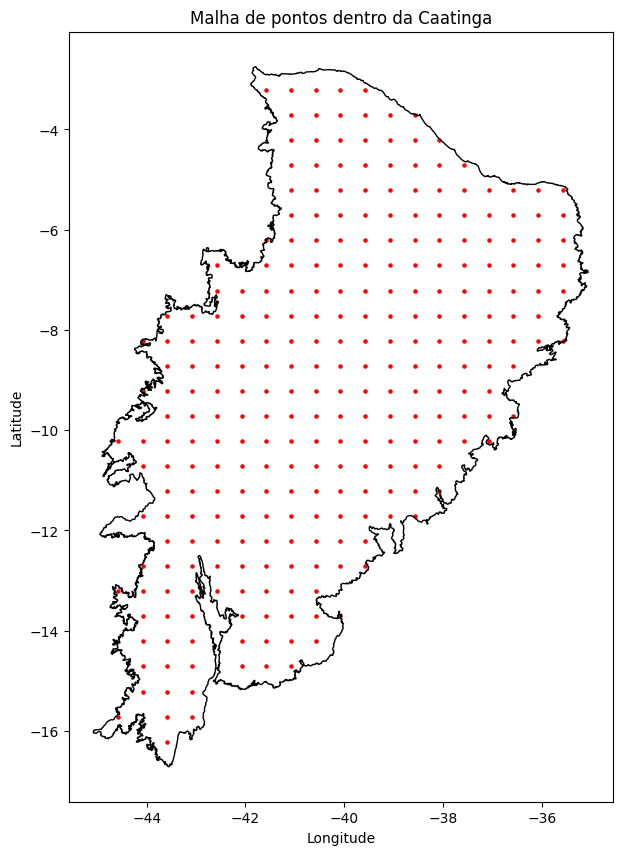

In [55]:
# Plotar a Caatinga e a malha de pontos
fig, ax = plt.subplots(figsize=(10, 10))
gdf_caatinga.boundary.plot(ax=ax, color='black', linewidth=1)
grid_gdf.plot(ax=ax, color='red', markersize=5)
plt.title('Malha de pontos dentro da Caatinga')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Atribuir IDs únicos a cada ponto
grid_gdf['id'] = ['SAT' + str(i) for i in range(len(grid_gdf))]

# Adicionar pontos fictícios ao redor do perímetro da Caatinga
minx, miny, maxx, maxy = caatinga.total_bounds
padding = 0.5  # Ajuste conforme necessário
extra_points = [
    [minx - padding, miny - padding],
    [minx - padding, maxy + padding],
    [maxx + padding, miny - padding],
    [maxx + padding, maxy + padding]
]

# Adicionar os novos pontos às coordenadas das estações
extra_points_geom = [Point(x, y) for x, y in extra_points]
extra_gdf = gpd.GeoDataFrame(extra_points_geom, columns=['geometry'], crs=gdf_caatinga.crs)

# Concatenar os pontos fictícios ao GeoDataFrame original
all_points_gdf = pd.concat([grid_gdf, extra_gdf], ignore_index=True)

# Extraindo coordenadas para criação dos polígonos de Voronoi
coords = np.array(list(zip(all_points_gdf.geometry.x, all_points_gdf.geometry.y)))

# Gerar os polígonos de Voronoi
vor = Voronoi(coords)

# Criar polígonos de Voronoi a partir dos vértices
polygons = []
for region in vor.regions:
    if not -1 in region and region:
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)

# Criar um GeoDataFrame com os polígonos de Voronoi
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons, crs=all_points_gdf.crs)

# Verificar e corrigir geometrias inválidas antes do clipping
gdf_voronoi['geometry'] = gdf_voronoi['geometry'].buffer(0)

# Clipping com o polígono da Caatinga para garantir que todos os polígonos estejam dentro da região
gdf_voronoi_clipped = gpd.GeoDataFrame(
    geometry=[poly.intersection(gdf_caatinga.unary_union) for poly in gdf_voronoi.geometry if not poly.is_empty],
    crs=gdf_voronoi.crs
)

# Remover geometrias vazias
gdf_voronoi_clipped = gdf_voronoi_clipped[~gdf_voronoi_clipped.is_empty]

In [57]:
# Associar o polígono ao ID da estação mais próxima
def find_nearest_station(polygon, stations):
    centroid = polygon.centroid
    distances = stations.geometry.apply(lambda x: centroid.distance(x))
    nearest_station = stations.loc[distances.idxmin()]
    return nearest_station['id']

# Aplicar a função para encontrar o ID da estação
gdf_voronoi_clipped['id'] = gdf_voronoi_clipped.geometry.apply(lambda poly: find_nearest_station(poly, grid_gdf))

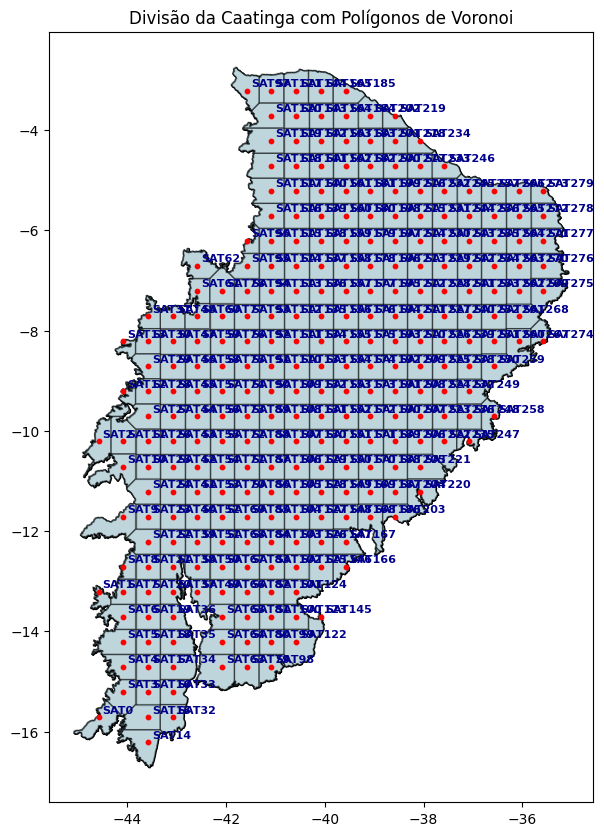

In [66]:
# Plotar o resultado
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o perímetro da Caatinga
gdf_caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plotar os polígonos de Voronoi
gdf_voronoi_clipped.plot(ax=ax, edgecolor='black', color='lightblue', alpha=0.5)

# Plotar os pontos
grid_gdf.plot(ax=ax, color='red', markersize=10)

# Adicionar o ID dos pontos no plot
for x, y, label in zip(grid_gdf.geometry.x, grid_gdf.geometry.y, grid_gdf['id']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='darkblue', weight='bold')

plt.title('Divisão da Caatinga com Polígonos de Voronoi')
plt.show()

In [65]:
# salvar o shapefile resultante
gdf_voronoi_clipped.to_file('../dados/shapefile_estacoes_divididas/caatinga_territorios_dividido_SAT.shp')

# Recuperando informação de temperatura para cada estação

In [69]:
import ee
import pandas as pd

In [70]:
ee.Authenticate(force=True)
service_account = 'pdi-618@projetopdi-430718.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '../dados/projetopdi-430718-5d4f0b0f6064.json')
ee.Initialize(credentials)


Successfully saved authorization token.


In [7]:
def get_modis_temperature_by_year_range(lat, lon, start_year, end_year):
    """
    Função para obter as temperaturas médias máximas e mínimas de superfície terrestre do MODIS para uma latitude, 
    longitude e intervalo de anos específico.
    
    Parâmetros:
    - lat (float): Latitude do local.
    - lon (float): Longitude do local.
    - start_year (int): Ano inicial do intervalo.
    - end_year (int): Ano final do intervalo.
    
    Retorna:
    - Lista de temperaturas médias máximas e mínimas de superfície terrestre em Celsius para cada ano no intervalo.
    """
    
    # Inicializar o ponto de interesse
    point = ee.Geometry.Point(lon, lat)
    
    # Definir datas de início e fim com base no intervalo de anos
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    
    # Coleção de dados MODIS de temperatura da superfície terrestre
    dataset = ee.ImageCollection('MODIS/061/MOD11A1') \
        .filterBounds(point) \
        .filterDate(start_date, end_date) \
        .select(['LST_Day_1km', 'LST_Night_1km'])
    
    # Verificar se imagens foram encontradas
    if dataset.size().getInfo() == 0:
        raise ValueError("Nenhuma imagem encontrada para o intervalo de anos e localização especificados.")
    
    # Lista para armazenar as temperaturas médias máximas e mínimas por ano
    temperaturas_anuais = []
    
    # Loop através dos anos no intervalo
    for year in range(start_year, end_year + 1):
        year_start = f'{year}-01-01'
        year_end = f'{year}-12-31'
        
        # Filtrar a coleção de dados para o ano específico
        year_images = dataset.filterDate(year_start, year_end)
        
        # Calcular as temperaturas médias diurna e noturna para o ano
        mean_temp_day_image = year_images.select('LST_Day_1km').median()
        mean_temp_night_image = year_images.select('LST_Night_1km').median()
        
        # Amostrar os valores das temperaturas no ponto de interesse
        try:
            temp_day_dict = mean_temp_day_image.sample(region=point, scale=1000).first().getInfo()
            temp_night_dict = mean_temp_night_image.sample(region=point, scale=1000).first().getInfo()
            
            if temp_day_dict is None or 'properties' not in temp_day_dict or temp_night_dict is None or 'properties' not in temp_night_dict:
                raise ValueError("Amostragem falhou ou não retornou dados válidos.")
            
            # Converter de Kelvin para Celsius
            temp_max_celsius = temp_day_dict['properties']['LST_Day_1km'] * 0.02 - 273.15
            temp_min_celsius = temp_night_dict['properties']['LST_Night_1km'] * 0.02 - 273.15
            
            temperaturas_anuais.append({'year': year, 'max_temperature': temp_max_celsius, 'min_temperature': temp_min_celsius})
        
        except Exception as e:
            raise ValueError(f"Erro ao obter temperatura para o ano {year}: {e}")
    
    return temperaturas_anuais

In [63]:
# Extraindo as coordenadas e IDs das estações
stations_df = grid_gdf[['id', 'geometry']].copy()
stations_df['latitude'] = stations_df.geometry.y
stations_df['longitude'] = stations_df.geometry.x

# Definir o intervalo de anos
start_year = 2003
end_year = 2022

# Inicializar uma lista para armazenar todos os dados de temperatura
all_temperatures = []

# Iterar sobre cada estação no dataframe
for index, station in stations_df.iterrows():
    lat = station['latitude']
    lon = station['longitude']
    id_estacao = station['id']
    
    try:
        # Obter as temperaturas para a estação atual
        temperaturas = get_modis_temperature_by_year_range(lat, lon, start_year, end_year)
        
        # Adicionar o ID da estação aos dados de temperatura
        for temp in temperaturas:
            temp['id_estacao'] = id_estacao
            temp['latitude'] = lat
            temp['longitude'] = lon
            all_temperatures.append(temp)
    
    except ValueError as e:
        print(f"Erro ao obter temperaturas para a estação {id_estacao}: {e}")

# Converter a lista de temperaturas para um DataFrame
temperature_df = pd.DataFrame(all_temperatures)

# Reorganizar colunas para melhor visualização
temperature_df = temperature_df[['id_estacao', 'year', 'latitude', 'longitude', 'max_temperature', 'min_temperature']]

# Exibir o DataFrame final
temperature_df.head()

id_estacao  year   latitude  longitude  max_temperature  min_temperature
0       SAT0  2003 -15.712637 -44.578141        28.046000        19.590000
1       SAT0  2004 -15.712637 -44.578141        26.398571        18.550000
2       SAT0  2005 -15.712637 -44.578141        27.144444        19.555000
3       SAT0  2006 -15.712637 -44.578141        25.992500        18.613333
4       SAT0  2007 -15.712637 -44.578141        27.308000        19.345000

In [64]:
# salvar o dataframe
temperature_df.to_csv('../dados/temperaturas_estacoes_modis.csv', index=False)

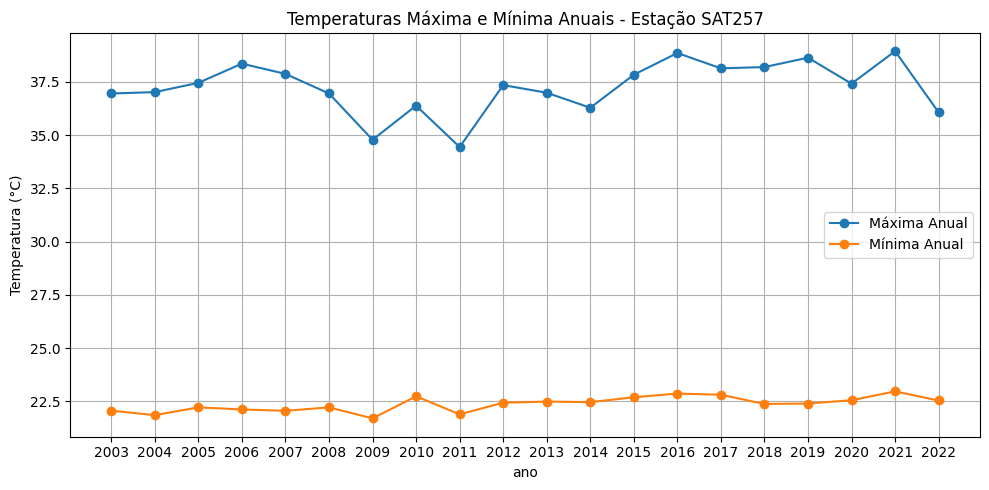

In [47]:
# abrir o arquivo CSV
temperature_df = pd.read_csv('../dados/temperaturas_estacoes_modis.csv')

# Filtrar os dados apenas para a estação SAT0
dados_SAT0 = temperature_df[temperature_df['id_estacao'] == 'SAT257']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_SAT0.groupby('year').agg(
    temperatura_max=('max_temperature', 'max'),
    temperatura_min=('min_temperature', 'min')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['year'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['year'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais - Estação SAT257')
plt.xticks(range(temperatura_anual['year'].min(), temperatura_anual['year'].max() + 1))  # Define os ticks do eixo x para cada year
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Separar os arquivos geotif por estação

In [70]:
def process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped):
    """
    Processa todos os arquivos GeoTIFF na pasta segmentacoes para todas as estações,
    salvando os resultados em pastas separadas por ano.

    Args:
    segmentacoes_dir (str): Caminho para a pasta contendo os arquivos GeoTIFF de entrada.
    output_base_dir (str): Diretório base onde os GeoTIFFs resultantes serão salvos.
    gdf_voronoi_clipped (GeoDataFrame): GeoDataFrame contendo os polígonos de Voronoi.
    """

    # Listar todos os arquivos GeoTIFF na pasta segmentacoes
    tiff_files = glob.glob(os.path.join(segmentacoes_dir, '*.tif'))

    # Obter os IDs únicos das estações
    estacao_ids = gdf_voronoi_clipped['id_estacao'].unique()

    for tiff_file in tiff_files:
        # Extrair o ano do nome do arquivo GeoTIFF
        year = os.path.basename(tiff_file).split('_')[-1].split('.')[0]

        # Criar diretório para o ano se não existir
        year_dir = os.path.join(output_base_dir, year)
        os.makedirs(year_dir, exist_ok=True)

        for estacao_id in estacao_ids:
            # Aplicar a função para salvar o TIFF mascarado
            save_masked_tiff(tiff_file, estacao_id, year_dir, gdf_voronoi_clipped)
            print(f"Salvo: {year_dir}/coverage_{estacao_id}_{year}.tif")


# Definir caminhos
segmentacoes_dir = '../dados/segmentacoes'
output_base_dir = '../dados/raster_tiff_caating_sat'

# Executar o processamento para todos os arquivos e estações
process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped)

Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT144_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT121_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT13_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT11_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT2_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT12_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT165_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT14_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT35_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT153_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT132_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT5_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT18_2003.tif
Salvo: ../dados/raster_tiff_caating_sat\2003/coverage_SAT0_2003.tif
Salvo: ../dados/raster_tiff_caat

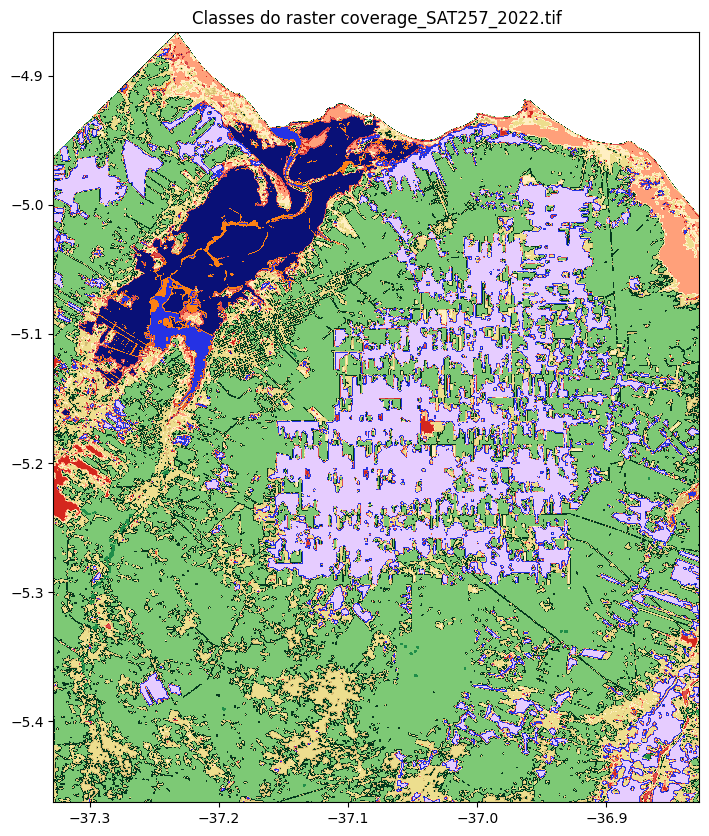

In [48]:
output_tif_path = '../dados/raster_tiff_caating_sat/2022/coverage_SAT257_2022.tif'
plot_tiff_with_classes(output_tif_path)

In [149]:
# Extrair informações do GeoTIFF salvo
sorted_class_counts = extract_classification_info(output_tif_path)

# Exibir as classificações e contagens
print("Contagem de superpixels por classe (ordenado):", sorted_class_counts)

Contagem de superpixels por classe (ordenado): {np.uint8(30): np.int64(1338), np.uint8(25): np.int64(3320), np.uint8(33): np.int64(4915), np.uint8(0): np.int64(7424), np.uint8(41): np.int64(21121), np.uint8(12): np.int64(27223), np.uint8(24): np.int64(42642), np.uint8(21): np.int64(123141), np.uint8(15): np.int64(269771), np.uint8(4): np.int64(1410352), np.uint8(3): np.int64(1537202)}


# Montagem do dataset para cada estação

In [178]:
# Carregar o shapefile do Voronoi previamente salvo
gdf_voronoi_clipped = gpd.read_file('../dados/shapefile_estacoes_divididas/caatinga_territorios_dividido_SAT.shp')
gdf_voronoi_clipped.rename(columns={'id': 'id_estacao'}, inplace=True)
gdf_voronoi_clipped.head()

id_estacao                                           geometry
0     SAT144  POLYGON ((-40.32814 -3.46264, -40.82814 -3.462...
1     SAT121  POLYGON ((-40.82814 -3.46264, -41.32814 -3.462...
2      SAT13  POLYGON ((-43.91258 -8.54708, -43.91273 -8.547...
3      SAT11  MULTIPOLYGON (((-44.32814 -9.72916, -44.32813 ...
4       SAT2  MULTIPOLYGON (((-44.32814 -9.71264, -44.32814 ...

In [179]:
# abrir o arquivo CSV com as temperaturas
temperature_df = pd.read_csv('../dados/temperaturas_estacoes_modis.csv')
# alterar nome max_temperature para temperatura_max e min_temperature para temperatura_min
temperature_df.rename(columns={'max_temperature': 'temperatura_max', 'min_temperature': 'temperatura_min', 'year': 'ano'}, inplace=True)
temperature_df.head()

id_estacao   ano   latitude  longitude  temperatura_max  temperatura_min
0       SAT0  2003 -15.712637 -44.578141        28.046000        19.590000
1       SAT0  2004 -15.712637 -44.578141        26.398571        18.550000
2       SAT0  2005 -15.712637 -44.578141        27.144444        19.555000
3       SAT0  2006 -15.712637 -44.578141        25.992500        18.613333
4       SAT0  2007 -15.712637 -44.578141        27.308000        19.345000

In [193]:
# Lista para armazenar os DataFrames de cada estação
datasets_completos = []
output_base_dir = '../dados/raster_tiff_caating_sat'
start_year = 2003
end_year = 2022

# Iterar sobre cada estação e criar o dataset completo
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Criar o dataset completo para a estação atual
    dataset_completo = criar_dataset_completo(temperature_df, output_base_dir, estacao_id, start_year, end_year)
    
    # Adicionar o ID da estação ao DataFrame
    dataset_completo['id_estacao'] = estacao_id
    
    # Adicionar o dataset da estação à lista
    datasets_completos.append(dataset_completo)

# Concatenar todos os DataFrames em um único DataFrame
dataset_completo_todas_estacoes = pd.concat(datasets_completos, ignore_index=True)

# Substituir valores NaN por 0
dataset_completo_todas_estacoes.fillna(0, inplace=True)

# Remover colunas onde todos os valores são 0
dataset_completo_todas_estacoes = dataset_completo_todas_estacoes.loc[:, (dataset_completo_todas_estacoes != 0).any(axis=0)]

# Exibir as primeiras linhas do DataFrame final
dataset_completo_todas_estacoes.head()

ano  temperatura_max_median  temperatura_min_median     41      12  \
0  2003                  30.938               23.140000  782.0  1015.0   
1  2004                  30.710               23.300000  739.0  1095.0   
2  2005                  35.570               23.700000    7.0   908.0   
3  2006                  31.055               23.240000    0.0   695.0   
4  2007                  32.840               23.463333    0.0   993.0   

       31      24       32       25        5  ...   39   62   29   46   11  \
0  5748.0  6090.0  13199.0  24262.0  44307.0  ...  0.0  0.0  0.0  0.0  0.0   
1  5889.0  6236.0  13400.0  22710.0  44468.0  ...  0.0  0.0  0.0  0.0  0.0   
2  5883.0  6598.0  13387.0  22402.0  44625.0  ...  0.0  0.0  0.0  0.0  0.0   
3  5917.0  6842.0  13444.0  23569.0  44735.0  ...  0.0  0.0  0.0  0.0  0.0   
4  6035.0  7180.0  13387.0  26257.0  44743.0  ...  0.0  0.0  0.0  0.0  0.0   

     9   20   49   50   13  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  

[5 rows x 29 columns]

In [194]:
# quantos anos de dados temos para cada estação?
dataset_completo_todas_estacoes['id_estacao'].value_counts()

id_estacao
SAT93     20
SAT144    20
SAT121    20
SAT13     20
SAT11     20
          ..
SAT18     20
SAT5      20
SAT132    20
SAT153    20
SAT35     20
Name: count, Length: 280, dtype: int64

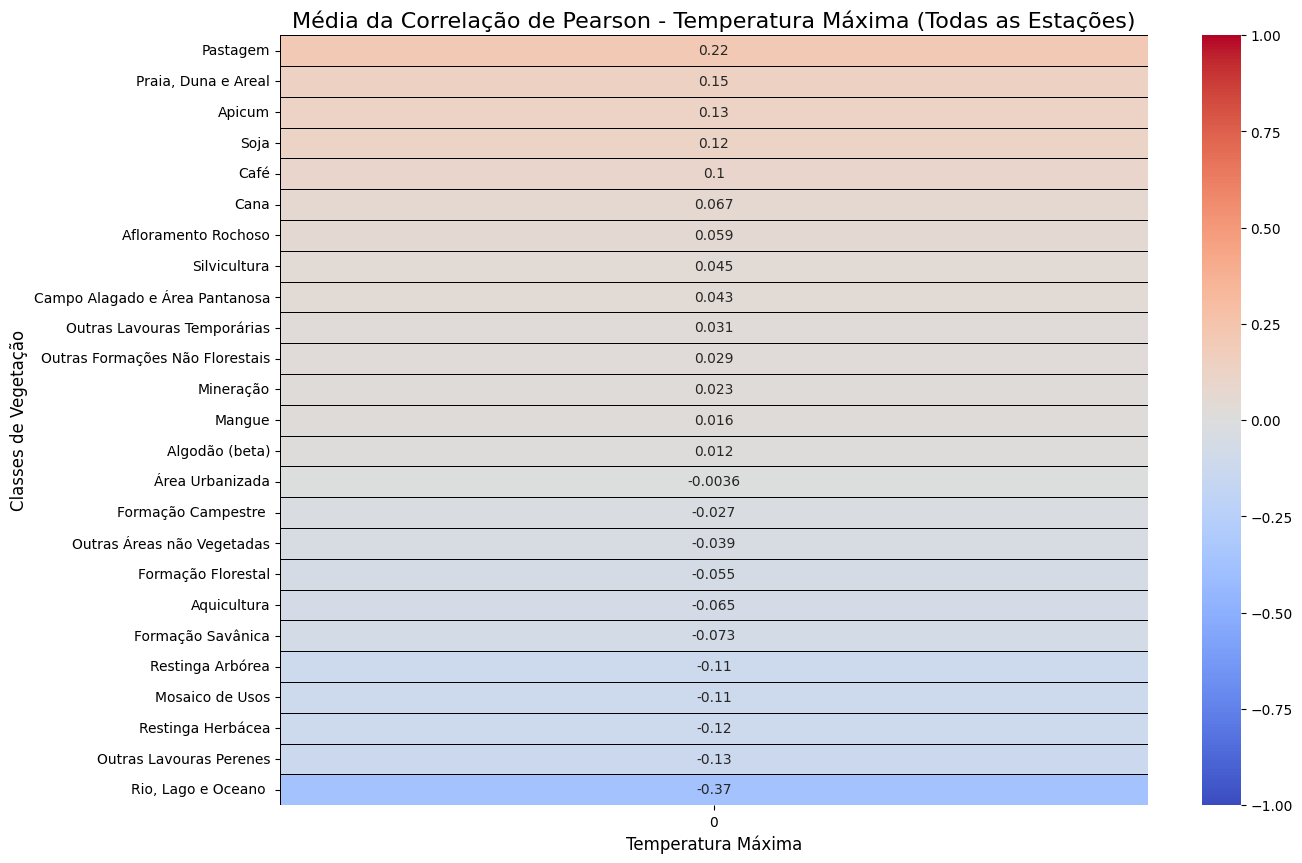

In [198]:
# Dicionário para armazenar as correlações de cada estação
correlacoes_por_estacao = {}

# Iterar por cada estação e calcular a correlação
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura máxima
    correlacao_temp_max = dados_para_correlacao.corr(method='pearson')['temperatura_max_median']
    
    # Remover a autocorrelação (correlação da temperatura máxima com ela mesma)
    correlacao_temp_max = correlacao_temp_max.drop(labels=['temperatura_max_median', 'temperatura_min_median'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao[estacao_id] = correlacao_temp_max

# Combinar todas as correlações e calcular a média
correlacoes_media = pd.DataFrame(correlacoes_por_estacao).mean(axis=1)

# Mapeando os nomes das classes no eixo y
correlacoes_media.index = correlacoes_media.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media = correlacoes_media.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura máxima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Máxima (Todas as Estações)', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Máxima', fontsize=12)
plt.show()

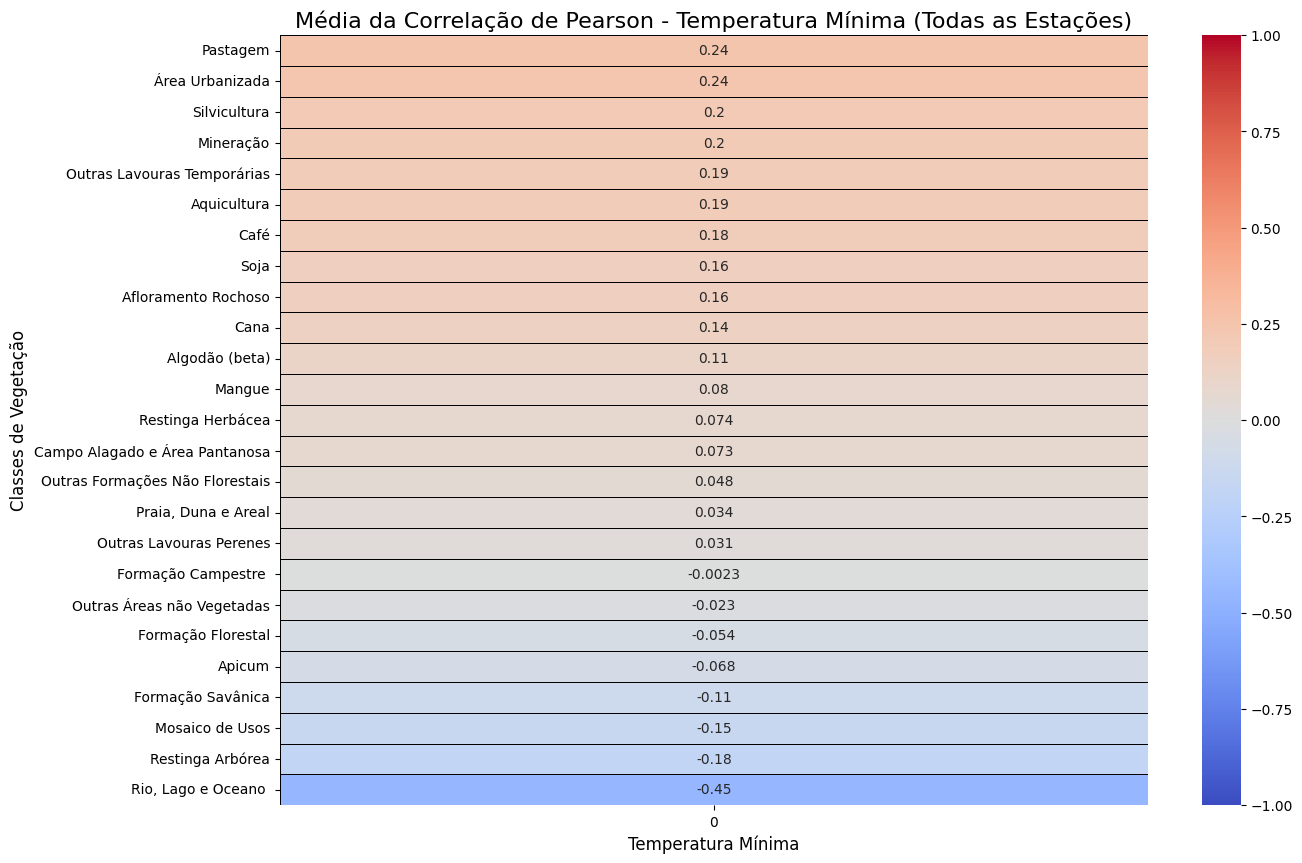

In [199]:
# Dicionário para armazenar as correlações de cada estação para temperatura mínima
correlacoes_por_estacao_min = {}

# Iterar por cada estação e calcular a correlação para a temperatura mínima
for estacao_id in gdf_voronoi_clipped['id_estacao']:
    # Filtrar os dados para a estação atual
    dados_estacao = dataset_completo_todas_estacoes[dataset_completo_todas_estacoes['id_estacao'] == estacao_id]
    
    # Remover colunas irrelevantes antes de calcular a correlação
    colunas_para_remover = ['ano', 'id_estacao']
    dados_para_correlacao = dados_estacao.drop(columns=colunas_para_remover)
    
    # Calcular a correlação de Pearson para a temperatura mínima
    correlacao_temp_min = dados_para_correlacao.corr(method='pearson')['temperatura_min_median']
    
    # Remover a autocorrelação (correlação da temperatura mínima com ela mesma)
    correlacao_temp_min = correlacao_temp_min.drop(labels=['temperatura_max_median', 'temperatura_min_median'])
    
    # Armazenar a correlação para a estação atual
    correlacoes_por_estacao_min[estacao_id] = correlacao_temp_min

# Combinar todas as correlações e calcular a média
correlacoes_media_min = pd.DataFrame(correlacoes_por_estacao_min).mean(axis=1)

# Mapeando os nomes das classes no eixo y
correlacoes_media_min.index = correlacoes_media_min.index.map(id_to_class_name)

# Ordenar as correlações da maior para a menor
correlacoes_media_min = correlacoes_media_min.sort_values(ascending=False)

# Plotar a correlação de Pearson média para a temperatura mínima
plt.figure(figsize=(14, 10))
sns.heatmap(correlacoes_media_min.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black', cbar=True)
plt.title('Média da Correlação de Pearson - Temperatura Mínima (Todas as Estações)', fontsize=16)
plt.ylabel('Classes de Vegetação', fontsize=12)
plt.xlabel('Temperatura Mínima', fontsize=12)
plt.show()

# Diferença entre temperatura da estação para temperatura do satélite

In [3]:
import cdsapi
from requests.exceptions import HTTPError
import xarray as xr
import time

In [ ]:
# Abrir o shapefile de estações
gdf_voronoi = gpd.read_file(('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp'))

In [7]:
# Calcular a média das temperaturas máxima e mínima para cada linha
combined_data['temperatura_media'] = (combined_data['temperatura_max'] + combined_data['temperatura_min']) / 2

# Agrupar por 'id_estacao' e 'ano' e calcular a média da temperatura_media
df_temperaturas_estacoes = combined_data.groupby(['id_estacao', 'ano']).agg({
    'temperatura_media': 'mean'
}).reset_index()

# Renomear a coluna para 'temperatura'
df_temperaturas_estacoes.rename(columns={'temperatura_media': 'temperatura'}, inplace=True)

# Exibir as primeiras linhas do DataFrame resultante
df_temperaturas_estacoes.head()

id_estacao   ano  temperatura
0       A305  2003    28.147999
1       A305  2004    27.932471
2       A305  2005    27.693376
3       A305  2006    29.259796
4       A305  2007    27.579004

In [11]:
def get_era5_temperature_by_year_range(lat, lon, start_year, end_year, output_dir='../dados/era5_temp'):
    """
    Função para obter as temperaturas médias anuais do ar a 2 metros de altura do ERA5 para uma latitude, 
    longitude e intervalo de anos específico.

    Parâmetros:
    - lat (float): Latitude do local.
    - lon (float): Longitude do local.
    - start_year (int): Ano inicial do intervalo.
    - end_year (int): Ano final do intervalo.
    - output_dir (str): Diretório para salvar os arquivos NetCDF.

    Retorna:
    - Lista de temperaturas médias anuais do ar em Celsius.
    """
    
    # Inicializar o cliente da API do CDS
    try:
        c = cdsapi.Client()
    except Exception as e:
        print(f"Erro ao inicializar o cliente CDS: {e}")
        return []
    
    # Garantir que o diretório de saída exista
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    temperaturas_anuais = []
    
    for year in range(start_year, end_year + 1):
        print(f"Baixando dados para o ano {year}...")
        
        try:
            # Definir parâmetros de download usando o dataset de médias mensais
            c.retrieve(
                'reanalysis-era5-single-levels-monthly-means',
                {
                    'product_type': 'monthly_averaged_reanalysis',
                    'variable': '2m_temperature',
                    'year': str(year),
                    'month': [f"{m:02d}" for m in range(1, 13)],
                    'time': '00:00',
                    'area': [
                        lat + 1.0, lon - 1.0,  # North, West
                        lat - 1.0, lon + 1.0   # South, East
                    ],
                    'format': 'netcdf',
                },
                f'{output_dir}/era5_temp_{year}.nc'
            )
            
            print(f"Dados para o ano {year} baixados com sucesso. Processando...")
            
            # Processar os dados NetCDF
            ds = xr.open_dataset(f'{output_dir}/era5_temp_{year}.nc')
            
            # Selecionar a temperatura a 2m no ponto específico
            temp = ds['t2m'].sel(
                latitude=lat,
                longitude=lon,
                method='nearest'
            )
            
            # Converter de Kelvin para Celsius
            temp_celsius = temp - 273.15
            
            # Calcular a média anual a partir das médias mensais
            temperatura_media = temp_celsius.mean(dim='date').item()
            
            temperaturas_anuais.append({'year': year, 'temperature': temperatura_media})
            
            # Fechar o dataset para liberar memória
            ds.close()
            print(f"Temperatura média para o ano {year}: {temperatura_media:.2f}°C")
            
        except HTTPError as http_err:
            print(f"HTTP error occurred ao baixar dados para o ano {year}: {http_err}")
            if http_err.response is not None:
                print(f"Conteúdo da resposta: {http_err.response.text}")
        except Exception as e:
            print(f"Erro ao baixar/processar dados para o ano {year}: {e}")
            continue
        
        # Pausa de 5 segundos para evitar sobrecarga na API
        time.sleep(5)
    
    return temperaturas_anuais

In [ ]:
# Criar uma lista para armazenar os resultados
resultados = []

# Iterar sobre cada estação no GeoDataFrame
for idx, row in gdf_voronoi.iterrows():
    id_estacao = row['id_estacao']
    lat = row['latitude']
    lon = row['longitude']
    
    try:
        # Obter as temperaturas ERA5 para o intervalo de 2003 a 2022
        temperaturas_anuais = get_era5_temperature_by_year_range(lat, lon, 2003, 2022)
        
        # Adicionar os resultados ao dataframe
        for temp_data in temperaturas_anuais:
            resultados.append({
                'id_estacao': id_estacao,
                'year': temp_data['year'],
                'temperature': temp_data['temperature']  # Temperatura do Ar
            })
    
    except Exception as e:
        print(f"Erro ao obter dados para a estação {id_estacao}: {e}")
        continue

# Criar um DataFrame a partir da lista de resultados
df_temperaturas_reanalisada = pd.DataFrame(resultados)

In [13]:
df_temperaturas_reanalisada.head()

id_estacao  year  temperature
0       A336  2004    27.022346
1       A336  2005    26.894407
2       A336  2006    26.883469
3       A336  2007    27.449907
4       A336  2008    26.734053

In [14]:
# salvar em um csv
df_temperaturas_reanalisada.to_csv('../dados/temperaturas_estacoes_era5.csv', index=False)

In [8]:
df_temperaturas_reanalisada = pd.read_csv('../dados/temperaturas_estacoes_era5.csv')

In [9]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [10]:
# Filtrando para o ano específico de 2022
year_filter = 2022
filtered_data = pd.merge(
    df_temperaturas_reanalisada[df_temperaturas_reanalisada['year'] == year_filter],
    df_temperaturas_estacoes[df_temperaturas_estacoes['ano'] == year_filter],
    on='id_estacao',
    how='inner'
)

# Calculando a diferença de temperatura preservando o sinal
filtered_data['temp_difference'] = filtered_data['temperature'] - filtered_data['temperatura']

# Mesclando com o shapefile Voronoi
gdf_voronoi_temp_filtered = gdf_voronoi.merge(
    filtered_data[['id_estacao', 'temp_difference']],
    on='id_estacao'
)

# Visualizar o DataFrame resultante
gdf_voronoi_temp_filtered.head()

id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
1       A365  -8.117939 -42.975721   
2       A416 -13.332500 -44.617500   
3       A433 -14.181944 -41.672222   
4       A308  -3.086667 -41.783056   

                                            geometry  temp_difference  
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...        -1.863923  
1  MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ...        -0.192163  
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...         0.903506  
3  POLYGON ((-42.21703 -13.71785, -42.21693 -13.7...        -0.488868  
4  POLYGON ((-41.5219 -3.55804, -41.52253 -3.5580...        -0.577440

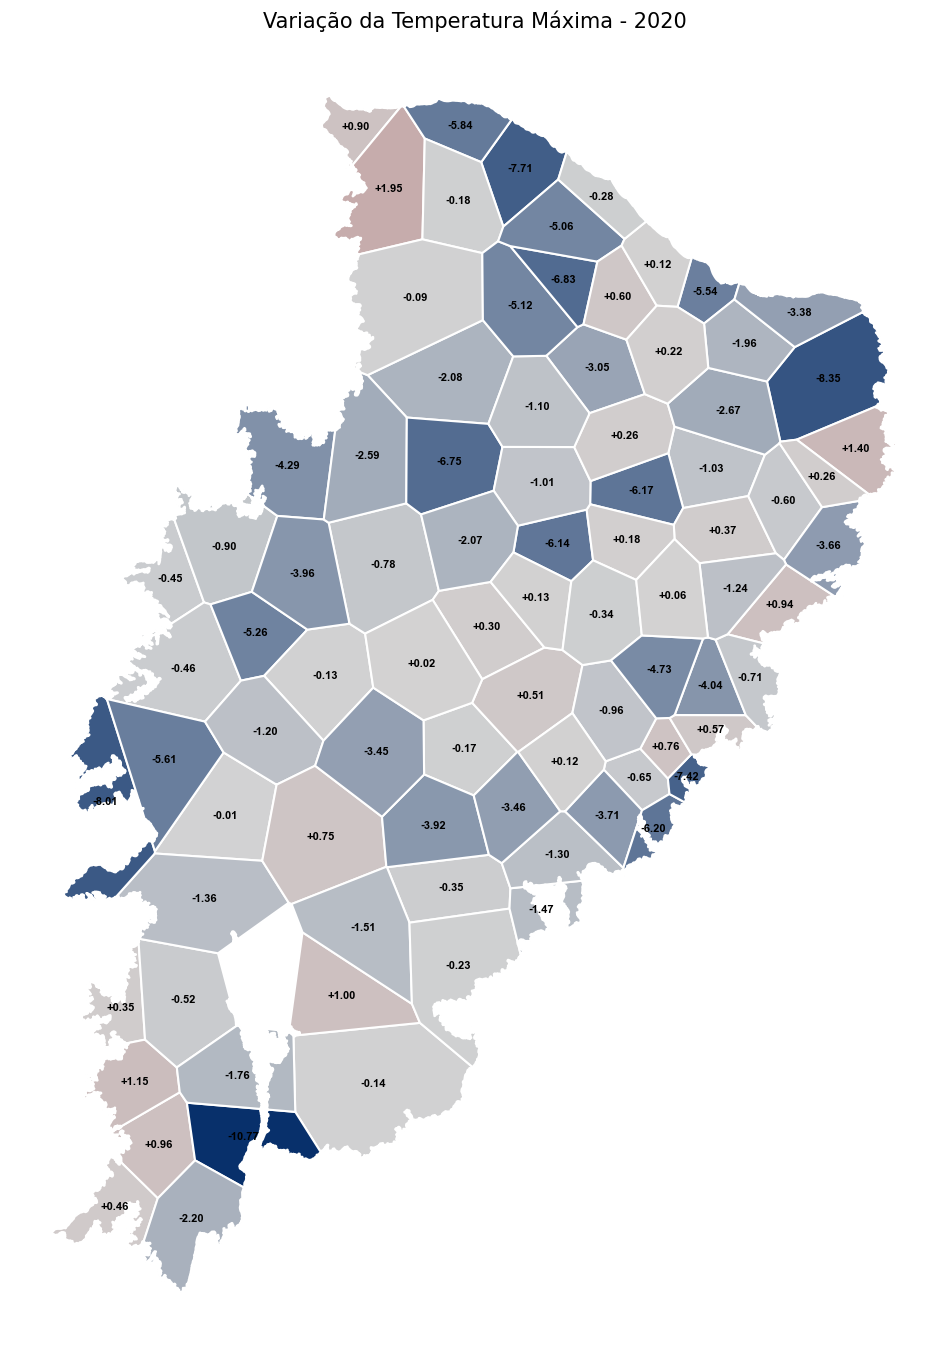

In [12]:
# Filtrando para o ano específico de 2022
year_filter = 2020
filtered_data = pd.merge(
    df_temperaturas_reanalisada[df_temperaturas_reanalisada['year'] == year_filter],
    df_temperaturas_estacoes[df_temperaturas_estacoes['ano'] == year_filter],
    on='id_estacao',
    how='inner'
)

# Calculando a diferença de temperatura preservando o sinal
filtered_data['temp_difference'] = filtered_data['temperature'] - filtered_data['temperatura']

# Mesclando com o shapefile Voronoi
gdf_voronoi_temp_filtered = gdf_voronoi.merge(
    filtered_data[['id_estacao', 'temp_difference']],
    on='id_estacao'
)

# Criar um colormap personalizado: azul escuro -> cinza claro -> vermelho escuro
colors = [
    (0.0, "#08306B"),  # Azul escuro
    (0.5, "#D3D3D3"),  # Cinza claro no meio
    (1.0, "#8B0000")   # Vermelho escuro
]
custom_cmap = LinearSegmentedColormap.from_list("BlueGrayRed", colors)

# Configurar a normalização com o centro em zero
vmin = filtered_data['temp_difference'].min()
vmax = filtered_data['temp_difference'].max()
max_abs = max(abs(vmin), abs(vmax))
norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0.0, vmax=max_abs)

# Criando o mapa para o ano de 2022
fig, ax = plt.subplots(1, 1, figsize=(12, 24))

# Plotando o mapa com o colormap personalizado
gdf_voronoi_temp_filtered.plot(
    column='temp_difference',
    ax=ax,
    cmap=custom_cmap,
    edgecolor='white',
    linewidth=1.5,
    norm=norm,
    legend=False,  # Adiciona a legenda
    legend_kwds={'label': "Diferença de Temperatura (°C)"}
)

# Adicionando o valor da diferença de temperatura com sinal em cada região
for idx, row in gdf_voronoi_temp_filtered.iterrows():
    # Calcula o centroide de forma mais robusta
    centroid = row['geometry'].centroid
    x, y = centroid.x, centroid.y
    temp_change = row['temp_difference']
    ax.text(
        x, y, f"{temp_change:+.2f}",  # Inclui o sinal (+/-)
        ha='center', va='center',
        fontsize=8,  # Ajuste o tamanho da fonte conforme necessário
        fontname='Arial',
        fontweight='bold',
        color='black'
    )

# Remover bordas externas do plot
ax.set_axis_off()
ax.set_title(f'Variação da Temperatura Máxima - {year_filter}', fontsize=15)
plt.show()

# Confiabilidade da temperatura com base na área

In [13]:
# Carregar o shapefile do Voronoi previamente salvo
gdf_voronoi_clipped = gpd.read_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')

In [14]:
gdf_voronoi_clipped.head()

id_estacao   latitude  longitude  \
0       A336  -8.441667 -43.865556   
1       A365  -8.117939 -42.975721   
2       A416 -13.332500 -44.617500   
3       A433 -14.181944 -41.672222   
4       A308  -3.086667 -41.783056   

                                            geometry  
0  MULTIPOLYGON (((-43.28134 -8.66269, -43.66635 ...  
1  MULTIPOLYGON (((-43.28134 -8.66269, -43.63515 ...  
2  MULTIPOLYGON (((-44.05675 -12.61621, -44.05717...  
3  POLYGON ((-42.21703 -13.71785, -42.21693 -13.7...  
4  POLYGON ((-41.5219 -3.55804, -41.52253 -3.5580...

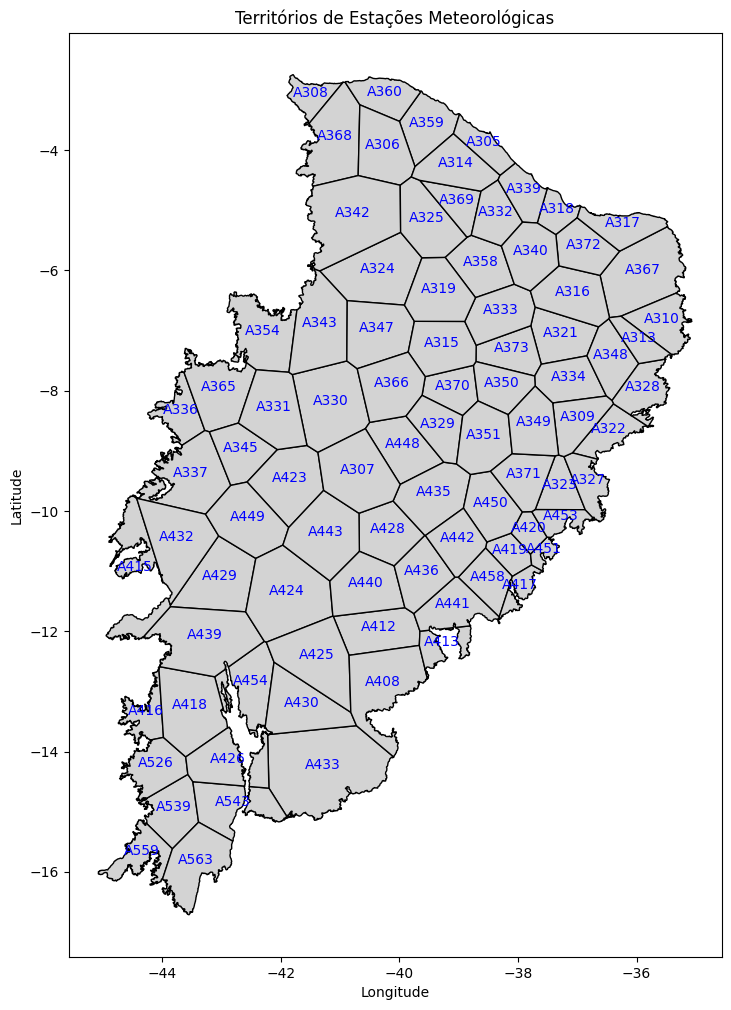

In [5]:
# Plotar o shapefile com IDs das estações
fig, ax = plt.subplots(figsize=(12, 12))

# Plotar os polígonos do shapefile
gdf_voronoi_clipped.plot(ax=ax, edgecolor='black', facecolor='lightgrey')

# Adicionar os IDs das estações no centro de cada polígono
for idx, row in gdf_voronoi_clipped.iterrows():
    # Obter o centroide de cada polígono
    centroid = row['geometry'].centroid
    # Adicionar o ID da estação no centro do polígono
    ax.annotate(row['id_estacao'], xy=(centroid.x, centroid.y), 
                horizontalalignment='center', fontsize=10, color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Territórios de Estações Meteorológicas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o gráfico
plt.show()

In [23]:
# Escolha a zona UTM apropriada para sua área. Aqui, usamos EPSG:32723 como exemplo.
utm_crs = "EPSG:32723"

# Reprojetar o GeoDataFrame de Voronoi para UTM
gdf_voronoi_clipped_utm = gdf_voronoi_clipped.to_crs(utm_crs)

# Criar um GeoDataFrame de pontos para as estações
gdf_pontos_estacoes = gpd.GeoDataFrame(
    gdf_voronoi_clipped[['id_estacao', 'latitude', 'longitude']],
    geometry=gpd.points_from_xy(gdf_voronoi_clipped['longitude'], gdf_voronoi_clipped['latitude']),
    crs="EPSG:4326"  # Sistema de coordenadas geográficas (WGS84)
)

# Reprojetar os pontos das estações para UTM
gdf_pontos_estacoes_utm = gdf_pontos_estacoes.to_crs(utm_crs)

# Criar um buffer de 10 km (10,000 metros) ao redor de cada estação
gdf_pontos_estacoes_utm['buffer_10km'] = gdf_pontos_estacoes_utm['geometry'].buffer(10000)  # 10 km em metros

# Inicializar uma lista para armazenar os resultados
results = []

# Iterar sobre cada estação
for idx, row in gdf_voronoi_clipped_utm.iterrows():
    estacao_id = row['id_estacao']
    area_voronoi = row['geometry'].area / 1e6  # Converter de m² para km²
    
    # Obter o buffer correspondente à estação
    buffer_geom = gdf_pontos_estacoes_utm.loc[gdf_pontos_estacoes_utm['id_estacao'] == estacao_id, 'buffer_10km']
    
    if buffer_geom.empty:
        # Se não houver buffer encontrado, assumir área de interseção como 0
        area_intersection_km2 = 0
    else:
        buffer = buffer_geom.iloc[0]
        # Calcular a interseção entre o polígono de Voronoi e o buffer
        intersection = row['geometry'].intersection(buffer)
        
        if intersection.is_empty:
            area_intersection_km2 = 0
        else:
            area_intersection_km2 = intersection.area / 1e6  # Converter de m² para km²
    
    # Calcular a cobertura
    cobertura = (area_intersection_km2 / area_voronoi) * 100 if area_voronoi > 0 else 0
    cobertura = min(cobertura, 100)  # Limitar a 100%
    
    # Armazenar os resultados
    results.append({
        'id_estacao': estacao_id,
        'area_km2': area_voronoi,
        'area_intersection_km2': area_intersection_km2,
        'cobertura': cobertura
    })

# Criar um DataFrame a partir dos resultados
df_results = pd.DataFrame(results)

# Mesclar os resultados com o GeoDataFrame original de Voronoi
gdf_voronoi_clipped_utm = gdf_voronoi_clipped_utm.merge(
    df_results,
    on='id_estacao',
    how='left'
)

# Preencher valores NaN com 0 (caso não haja interseção)
gdf_voronoi_clipped_utm['area_intersection_km2'] = gdf_voronoi_clipped_utm['area_intersection_km2'].fillna(0)
gdf_voronoi_clipped_utm['cobertura'] = gdf_voronoi_clipped_utm['cobertura'].fillna(0)

# Visualizar os resultados
gdf_voronoi_clipped_utm[['id_estacao', 'area_km2', 'area_intersection_km2', 'cobertura']].head()

id_estacao      area_km2  area_intersection_km2  cobertura
0       A336   6148.200030             313.654849   5.101572
1       A365  12066.263616             313.654849   2.599436
2       A416   4792.326631             175.588758   3.663956
3       A433  28347.908334             313.654849   1.106448
4       A308   4171.281870             300.349337   7.200409

C:\Users\arthu\AppData\Local\Temp\ipykernel_11044\1886563613.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


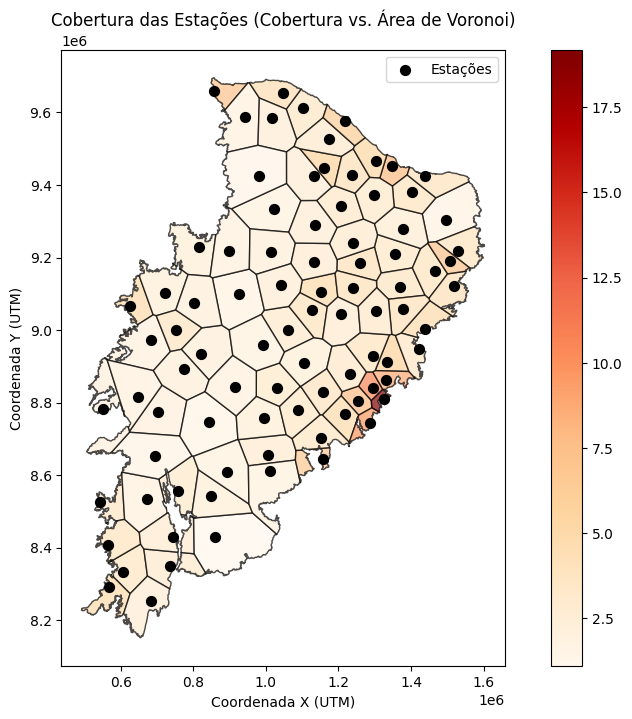

In [25]:
# Plotar os polígonos de Voronoi com base nas áreas de confiabilidade
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plotar os polígonos de Voronoi com um mapa de cores baseado na confiabilidade
gdf_voronoi_clipped_utm.plot(
    column='cobertura',
    ax=ax,
    legend=True,
    cmap='OrRd',
    edgecolor='black',
    figsize=(10, 10),
    alpha=0.7
)

# Plotar os buffers das estações
gdf_pontos_estacoes_utm.set_geometry('buffer_10km').plot(
    ax=ax,
    color='blue',
    alpha=0.2,
    edgecolor='blue',
    label='Buffer 10 km'
)

# Plotar os pontos das estações
gdf_pontos_estacoes_utm.plot(
    ax=ax,
    color='black',
    markersize=50,
    label='Estações'
)

# Adicionar título e legendas
plt.title('Cobertura das Estações (Cobertura vs. Área de Voronoi)')
plt.xlabel('Coordenada X (UTM)')
plt.ylabel('Coordenada Y (UTM)')
plt.legend()
plt.show()